<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/Tutorials/atomsci/ddm/examples/tutorials/08_AMPL_EDA_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Part two: visualizing results of hyperparameter search and predictions from best models (read-only)
**Please note that this template read-only notebook is designed for begineers and provides tips on how to identify good performing models. Our suggestion is use this notebook after you have carried out your HPO search and have access to several models. Please run this notebook on systems with large diskspace and dedicated resources (RAM, CPU)**

# Scope of the tutorial
* Visualize the hyper parameter search results
* Extract the performance metrics of all the models
* Examine the effect of RF Hyperparameters on the mode performance

The tutorial will try to answer the following questions. Even if you didn't get good models for regression, try to create a few of each in order to perform the visualizations for your data.
- Describe each visualization plots
  - What's being plotted? 
  - What are X and Y axes? Add labels and titles to each plot for clarification
    - And dont forget to add other information needed to understand the plot
- Interpret what you see in each plot
  - Hyperparameter searching:
    - Do your models generalize well?
    - Do you see overfitting? 
    - Do you think you chose the right hyperparameters
    - If you trained more models, what additional hyperparameters would you try?
    - What combination of features, model types and hyperparameters generally yields the best models?
- Model predictions:
  - Show your best random forest regression model (even if it's not great). How uncertain are your predictions?
    - Interpret the uncertainty calibration curve. See the [AMPL paper](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b01053) for more details.
    - Choose your best models based on different metrics and compare: 
      - do you see any differences or similarities in model performance? 
      - What do you think the best metric is for your model?
    - what limitations do you see in your model predictions?
    - when you predict on new data (no ground truth available), can you identify whether your new data is within the applicability domain (https://www.nature.com/articles/s41467-020-17112-9) of the model?
    - when you predict on data from a different target, how do your target predictions compare with the other target's ground truth? 
    - Are your two targets very similar or different when it comes to which compounds are most potent?

# Install AMPL packages

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install deepchem-nightly

import deepchem
deepchem.__version__

! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [ ]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/H1_std.csv

# Load packages and dataset

In [ ]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import requests
import sys

In [ ]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data
from atomsci.ddm.pipeline import compare_models as cmp

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()

import pandas as pd
import os, json, sys, glob, pickle

In [ ]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HTR3A_excape_curated.csv

--2021-05-20 17:58:57--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HTR3A_excape_curated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221217 (216K) [text/plain]
Saving to: ‘HTR3A_excape_curated.csv.3’

HTR3A_excape_curate 100%[===================>] 216.03K  --.-KB/s    in 0.02s   

2021-05-20 17:58:57 (8.67 MB/s) - ‘HTR3A_excape_curated.csv.3’ saved [221217/221217]



In [ ]:
h1 = pd.read_csv("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HTR3A_excape_curated.csv")

In [ ]:
h1.Activity_Flag.value_counts()

A    539
N     57
Name: Activity_Flag, dtype: int64

In [ ]:
h1 = h1.rename(columns= {"Activity_Flag" : "active"})

In [ ]:
h1.active = h1.active.map(dict(A=1, N=0))
h1 = h1.replace(to_replace=['A', 'N'], value=[1, 0])

In [ ]:
h1.active.value_counts()

1    539
0     57
Name: active, dtype: int64

In [ ]:
h1.head()

,compound_id,Original_Entry_ID,Entrez_ID,active,PXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,ABIDZKZAFOTHFB-CCUGXXBONA-N,CHEMBL1271790,3359,1.0,8.17000,chembl20,674333,9606,HTR3A,2102,InChI=1/C21H28N4O3/c1-13-11-27-12-14(2)25(13)2...,C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...,C[C@H]1COC[C@H](C)N1c1nc2c(C(=O)N[C@@H]3CN4CCC...,8.170000,NaN,0.000000,0
1,ABSDJNLAUZQHJY-UHFFFAOYNA-N,CHEMBL2205048,3359,1.0,7.21000,chembl20,880265,9606,HTR3A,2102,InChI=1/C17H20N2OS/c1-20-14-5-4-6-15(13-14)21-...,N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC,COc1cccc(Sc2ccccc2N2CCNCC2)c1,7.210000,NaN,0.000000,0
2,ACKJXXOVSOCBPX-PHLAQJRANA-N,11376655,79246,1.0,8.25181,pubchem,652569,10116,HTR3A,2102,InChI=1/C36H46N6O/c1-26-33(27-14-6-9-17-30(27)...,O=C(NCCCCCCCNC=1C=2CCCCC2N=C3C1C=CC=C3)C4=C(C(...,Cc1c(N2CCN(C)CC2)nc2ccccc2c1C(=O)NCCCCCCCNc1c2...,8.250905,0.00128,0.010968,0
3,ADYMTDFOOCWUHC-UHFFFAOYNA-N,CHEMBL305582,3359,1.0,8.13000,chembl20,3480,9606,HTR3A,2102,InChI=1/C19H22N4/c1-2-6-16(7-3-1)10-13-23-18-9...,C=1(N(C2=CC=CC=C2N1)CCC3=CC=CC=C3)N4CCNCC4,c1ccc(CCn2c(N3CCNCC3)nc3ccccc32)cc1,8.130000,NaN,0.000000,0
4,AFLJKKMTBWNZFE-KAASGWQYNA-N,CHEMBL378349,3359,1.0,6.76000,chembl20,851152,9606,HTR3A,2102,InChI=1/C16H18N2OS/c19-16(13-2-1-12-5-8-20-15(...,C1N2CCC([C@@H](NC(C3=CC4=C(C=C3)C=CS4)=O)C2)C1,O=C(N[C@H]1CN2CCC1CC2)c1ccc2ccsc2c1,6.760000,NaN,0.000000,0


In [ ]:
h1[~h1.active.isna()]['PXC50'].describe()

count    596.000000
mean       6.955584
std        1.475104
min        3.060000
25%        5.757812
50%        7.135970
75%        8.110877
max       10.500000
Name: PXC50, dtype: float64

In [ ]:
h1[h1['active'] == 1].PXC50.describe()

count    57.000000
mean      4.354912
std       0.367919
min       3.060000
25%       4.000000
50%       4.400000
75%       4.640000
max       4.940000
Name: PXC50, dtype: float64

In [ ]:
h1[h1['active'] == 0].PXC50.describe()

count    57.000000
mean      4.354912
std       0.367919
min       3.060000
25%       4.000000
50%       4.400000
75%       4.640000
max       4.940000
Name: PXC50, dtype: float64

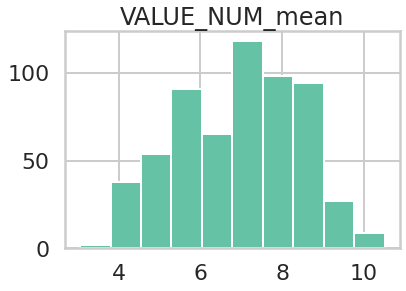

In [ ]:
h1=h1[~h1.VALUE_NUM_mean.isna()]
h1=h1[h1.VALUE_NUM_mean>2]
h1.hist('VALUE_NUM_mean');

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Edit some AMPL functions to include xgboost parameters
Just run this code once

# compare_models   in get_summary_perf_tables 

In [ ]:
from atomsci.ddm.pipeline import predict_from_model as pfm

In [ ]:
nan = np.float32('nan')
def get_summary_perf_tables(collection_names=None, filter_dict={}, result_dir=None, prediction_type='regression', verbose=False):
    """
    Load model parameters and performance metrics from model tracker for all models saved in the model tracker DB under
    the given collection names (or result directory if Model tracker is not available) with the given prediction type. Tabulate the parameters and metrics including:
        dataset (assay name, target, parameter, key, bucket)
        dataset size (train/valid/test/total)
        number of training folds
        model type (NN or RF)
        featurizer
        transformation type
        metrics: r2_score, mae_score and rms_score for regression, or ROC AUC for classification

    result_dir: use result_dir when the model tracker is not available. Use a list format if you have multiple result direcotries.
    """
    collection_list = []
    model_uuid_list = []
    time_built_list = []
    prediction_type_list = []
    model_type_list = []
    dataset_key_list = []
    bucket_list = []
    param_list = []
    featurizer_list = []
    desc_type_list = []
    transform_list = []
    dset_size_list = []
    splitter_list = []
    split_strategy_list = []
    split_uuid_list = []
    rf_estimators_list = []
    rf_max_features_list = []
    rf_max_depth_list = []
    best_epoch_list = []
    max_epochs_list = []
    learning_rate_list = []
    layer_sizes_list = []
    dropouts_list = []
    xgb_gamma_list = []
    xgb_learning_rate_list = []
    umap_dim_list = []
    umap_targ_wt_list = []
    umap_neighbors_list = []
    umap_min_dist_list = []
    split_uuid_list=[]


    if prediction_type == 'regression':
        score_types = ['r2_score', 'mae_score', 'rms_score']
    else:
        # TODO: add more classification metrics later
        score_types = ['roc_auc_score', 'prc_auc_score', 'accuracy_score', 'precision', 'recall_score', 'npv', 'matthews_cc', 'kappa','cross_entropy']

    subsets = ['train', 'valid', 'test']
    score_dict = {}
    ncmpd_dict = {}
    for subset in subsets:
        score_dict[subset] = {}
        for score_type in score_types:
            score_dict[subset][score_type] = []
        ncmpd_dict[subset] = []

    metadata_list_dict = {}
    if result_dir:
        if isinstance(result_dir, str):
            result_dir = [result_dir]
        for rd in result_dir:
            if rd not in metadata_list_dict:
                metadata_list_dict[rd] = []
            for dirpath, dirnames, filenames in os.walk(rd):
                if "model_metadata.json" in filenames:
                    with open(os.path.join(dirpath, 'model_metadata.json')) as f:
                        metadata_dict = json.load(f)
                    metadata_list_dict[rd].append(metadata_dict)

    for ss in metadata_list_dict:
        for i, metadata_dict in enumerate(metadata_list_dict[ss]):
            if (i % 10 == 0) and verbose:
                print('Processing collection %s model %d' % (ss, i))
            # Check that model has metrics before we go on
            if not 'training_metrics' in metadata_dict:
                continue
            collection_list.append(ss)
            model_uuid = metadata_dict['model_uuid']
            model_uuid_list.append(model_uuid)
            time_built = metadata_dict['time_built']
            time_built_list.append(time_built)

            model_params = metadata_dict['model_parameters']
            model_type = model_params['model_type']
            model_type_list.append(model_type)
            prediction_type_list.append(model_params['prediction_type'])
            featurizer = model_params['featurizer']
            featurizer_list.append(featurizer)
            if 'descriptor_specific' in metadata_dict:
                desc_type = metadata_dict['descriptor_specific']['descriptor_type']
            elif featurizer in ['graphconv', 'ecfp']:
                desc_type = featurizer
            else:
                desc_type = ''
            desc_type_list.append(desc_type)
            dataset_key = metadata_dict['training_dataset']['dataset_key']
            bucket = metadata_dict['training_dataset']['bucket']
            dataset_key_list.append(dataset_key)
            bucket_list.append(bucket)
            dset_metadata = metadata_dict['training_dataset']['dataset_metadata']
            param = metadata_dict['training_dataset']['response_cols'][0]
            param_list.append(param)
            transform_type = metadata_dict['training_dataset']['feature_transform_type']
            transform_list.append(transform_type)
            split_params = metadata_dict['splitting_parameters']
            splitter_list.append(split_params['splitter'])
            split_uuid_list.append(split_params.get('split_uuid', ''))
            split_strategy = split_params['split_strategy']
            split_strategy_list.append(split_strategy)

            if 'umap_specific' in metadata_dict:
                umap_params = metadata_dict['umap_specific']
                umap_dim_list.append(umap_params['umap_dim'])
                umap_targ_wt_list.append(umap_params['umap_targ_wt'])
                umap_neighbors_list.append(umap_params['umap_neighbors'])
                umap_min_dist_list.append(umap_params['umap_min_dist'])
            else:
                umap_dim_list.append(nan)
                umap_targ_wt_list.append(nan)
                umap_neighbors_list.append(nan)
                umap_min_dist_list.append(nan)

            if model_type == 'NN':
                nn_params = metadata_dict['nn_specific']
                max_epochs_list.append(nn_params['max_epochs'])
                best_epoch_list.append(nn_params['best_epoch'])
                learning_rate_list.append(nn_params['learning_rate'])
                layer_sizes_list.append(','.join(['%d' % s for s in nn_params['layer_sizes']]))
                dropouts_list.append(','.join(['%.2f' % d for d in nn_params['dropouts']]))
                rf_estimators_list.append(nan)
                rf_max_features_list.append(nan)
                rf_max_depth_list.append(nan)
                xgb_gamma_list.append(nan)
                xgb_learning_rate_list.append(nan)
            elif model_type == 'RF':
                rf_params = metadata_dict['rf_specific']
                rf_estimators_list.append(rf_params['rf_estimators'])
                rf_max_features_list.append(rf_params['rf_max_features'])
                rf_max_depth_list.append(rf_params['rf_max_depth'])
                max_epochs_list.append(nan)
                best_epoch_list.append(nan)
                learning_rate_list.append(nan)
                layer_sizes_list.append(nan)
                dropouts_list.append(nan)
                xgb_gamma_list.append(nan)
                xgb_learning_rate_list.append(nan)
            elif model_type == 'xgboost':
                # TODO: Add xgboost parameters
                xg_params = metadata_dict['xgb_specific']
                xgb_gamma_list.append(xg_params['xgb_gamma'])
                xgb_learning_rate_list.append(xg_params['xgb_learning_rate'])
                max_epochs_list.append(nan)
                best_epoch_list.append(nan)
                learning_rate_list.append(nan)
                layer_sizes_list.append(nan)
                dropouts_list.append(nan)
                rf_estimators_list.append(nan)
                rf_max_features_list.append(nan)
                rf_max_depth_list.append(nan)
            else:
                raise Exception('Unexpected model type %s' % model_type)

            # Get model metrics for this model
            metrics_dicts = metadata_dict['training_metrics']
            #print("Got %d metrics dicts for model %s" % (len(metrics_dicts), model_uuid))
            subset_metrics = {}
            for metrics_dict in metrics_dicts:
                if metrics_dict['label'] == 'best':
                    subset = metrics_dict['subset']
                    subset_metrics[subset] = metrics_dict['prediction_results']
            if split_strategy == 'k_fold_cv':
                dset_size = subset_metrics['train']['num_compounds'] + subset_metrics['test']['num_compounds']
            else:
                dset_size = subset_metrics['train']['num_compounds'] + subset_metrics['valid']['num_compounds'] + subset_metrics['test']['num_compounds']
            for subset in subsets:
                subset_size = subset_metrics[subset]['num_compounds']
                for score_type in score_types:
                    try:
                        score = subset_metrics[subset][score_type]
                    except KeyError:
                        score = float('nan')
                    score_dict[subset][score_type].append(score)
                ncmpd_dict[subset].append(subset_size)
            dset_size_list.append(dset_size)

    col_dict = dict(
                    collection=collection_list,
                    model_uuid=model_uuid_list,
                    time_built=time_built_list,
                    prediction_type=prediction_type_list,
                    model_type=model_type_list,
                    featurizer=featurizer_list,
                    features=desc_type_list,
                    transformer=transform_list,
                    splitter=splitter_list,
                    split_strategy=split_strategy_list,
                    split_uuid=split_uuid_list,
                    umap_dim=umap_dim_list,
                    umap_targ_wt=umap_targ_wt_list,
                    umap_neighbors=umap_neighbors_list,
                    umap_min_dist=umap_min_dist_list,
                    layer_sizes=layer_sizes_list,
                    dropouts=dropouts_list,
                    learning_rate=learning_rate_list,
                    best_epoch=best_epoch_list,
                    max_epochs=max_epochs_list,
                    rf_estimators=rf_estimators_list,
                    rf_max_features=rf_max_features_list,
                    rf_max_depth=rf_max_depth_list,
                    xgb_gamma = xgb_gamma_list,
                    xgb_learning_rate = xgb_learning_rate_list,
                    dataset_bucket=bucket_list,
                    dataset_key=dataset_key_list,
                    dataset_size=dset_size_list,
                    parameter=param_list
                    )

    perf_df = pd.DataFrame(col_dict)
    for subset in subsets:
        ncmpds_col = '%s_size' % subset
        perf_df[ncmpds_col] = ncmpd_dict[subset]
        for score_type in score_types:
            metric_col = '%s_%s' % (subset, score_type)
            perf_df[metric_col] = score_dict[subset][score_type]

    return perf_df

from atomsci.ddm.pipeline import predict_from_model as pfm

def predict_from_model_file(model_path, input_df, id_col='compound_id', smiles_col='rdkit_smiles',
                     response_col=None, is_featurized=False, dont_standardize=False):
    """
    Loads a pretrained model from a model tarball file and runs predictions on compounds in an input
    data frame.

    Args:
        model_path (str): File path of the model tarball file.

        input_df (DataFrame): Input data to run predictions on; must at minimum contain SMILES strings.

        id_col (str): Name of the column containing compound IDs. If none is provided, sequential IDs will be
        generated.

        smiles_col (str): Name of the column containing SMILES strings; required.

        response_col (str): Name of an optional column containing actual response values; if it is provided, 
        the actual values will be included in the returned data frame to make it easier for you to assess performance.

        dont_standardize (bool): By default, SMILES strings are salt-stripped and standardized using RDKit; 
        if you have already done this, or don't want them to be standardized, set dont_standardize to True.

    Return: 
        A data frame with compound IDs, SMILES strings and predicted response values. Actual response values
        will be included if response_col is provided. Standard prediction error estimates will be included
        if the model was trained with uncertainty=True. Note that the predicted and actual response
        columns will be labeled according to the response_col setting in the original training data,
        not the response_col passed to this function; e.g. if the original model response_col was 'pIC50',
        the returned data frame will contain columns 'pIC50_actual', 'pIC50_pred' and 'pIC50_std'.
    """

    input_df, pred_params = pfm._prepare_input_data(input_df, id_col, smiles_col, response_col, dont_standardize)

    has_responses = ('response_cols' in pred_params)
    pred_params = parse.wrapper(pred_params)

    pipe = mp.create_prediction_pipeline_from_file(pred_params, reload_dir=None, model_path=model_path)
    if pipe.params.model_type == 'xgboost':
        pipe.params.uncertainty = False
    pred_df = pipe.predict_full_dataset(input_df, contains_responses=has_responses, is_featurized=is_featurized,
                                        dset_params=pred_params)
    pred_df = pred_df.sort_values(by=id_col)
    return pred_df

# Visualize hyper parameter search
- you can use regression or classification models for this, just choose a different metric for the y-axis
- box plots work well if you did a grid search, scatter plots better if you did a HPO optimization
- LOTS of parameters to look at, think about questions you have for the data:
  - how do train, valid and test metrics look?
  - which features are best for modeling the data?
  - which hp's are the best?
  - which models are the best?

#### Get a table of performance metrics of all models in your directory

In [ ]:
# slow the first time after connecting your google drive
result_dir = '/content/HTR3A_models'
perf_df = cmp.get_summary_perf_tables(collection_names=None, filter_dict={}, 
                                  prediction_type = 'classification', 
                                  result_dir=result_dir, 
                                  verbose=False)

In [ ]:
perf_df = perf_df[perf_df.rf_estimators!=500]

In [ ]:
perf_df.pre

,collection,ampl_version,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_bal_accuracy,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_bal_accuracy,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_bal_accuracy,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa


In [ ]:
perf_df = perf_df[perf_df.prediction_type=='classification']

AttributeError: ignored

In [ ]:

perf_df.sort_values(by="valid_roc_auc_score", ascending=False).head()

NameError: ignored

In [ ]:
cmp.perf_df.groupby(by=['model_type', 'features']).count()[['model_uuid']]

model_uuid
model_type features                    
RF         ecfp                     224
           mordred_filtered         294
           rdkit_raw                211

#### Examine R2 scores from train, valid and test sets
- examine MAE or RMS scores instead. Do you see differences?
- Play around with hues from different hyperparameters. Do you see any trends?

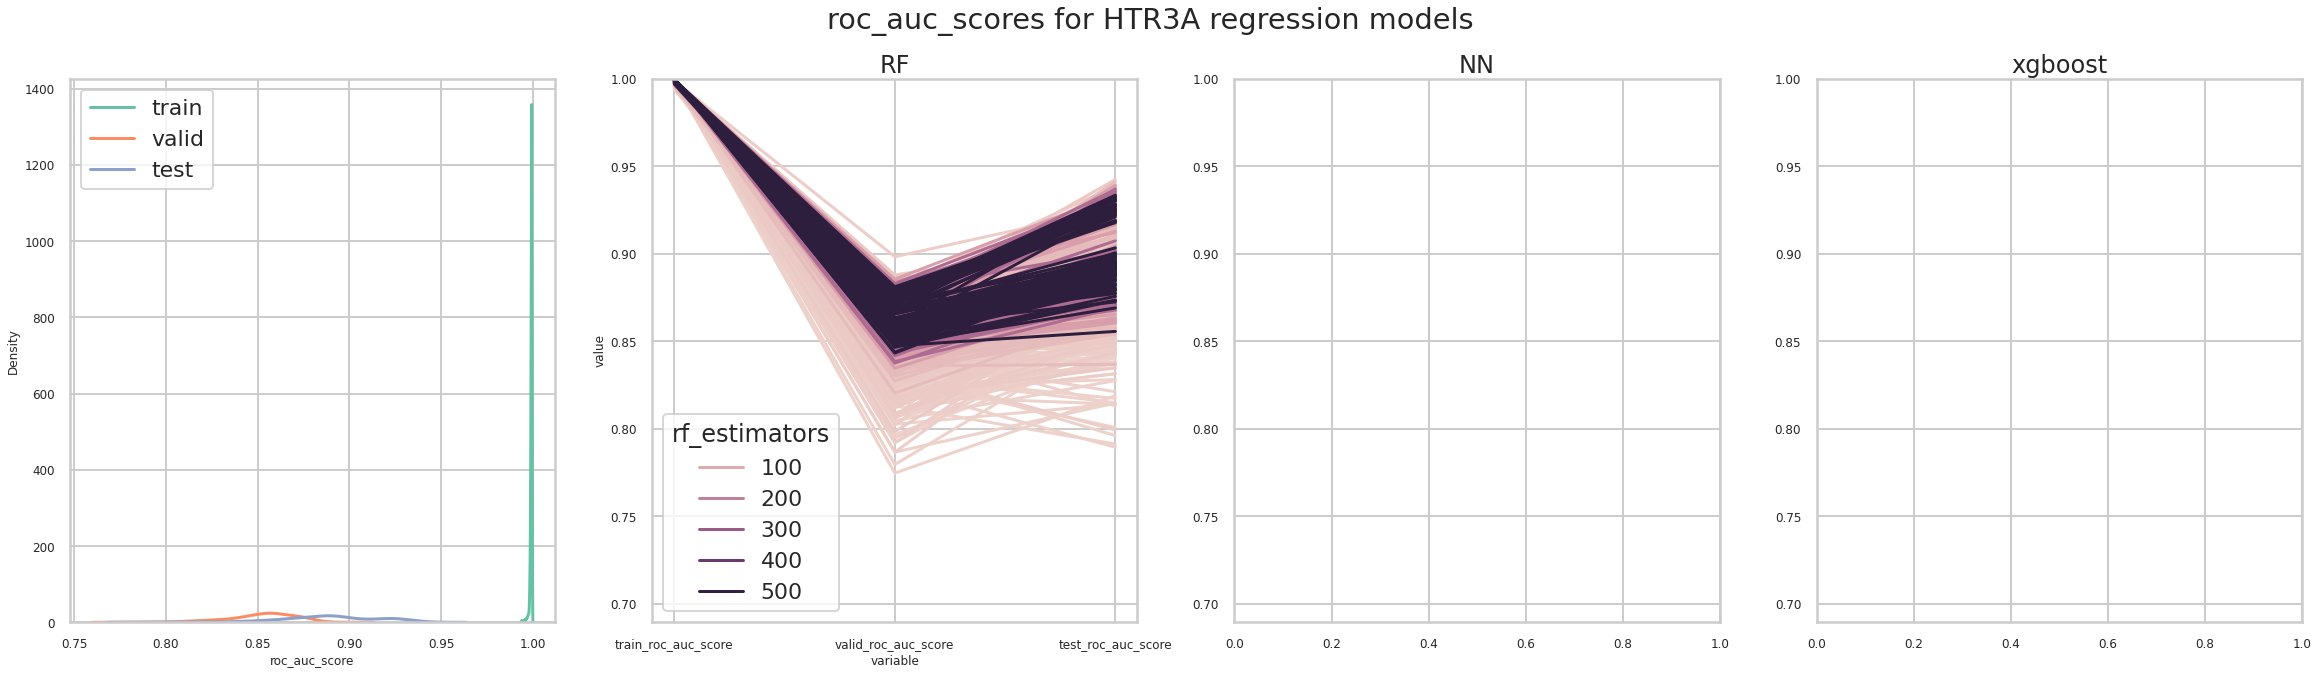

In [ ]:
# what are the scores like for train, valid and test sets?

scoretype='roc_auc_score'
subset='valid'
winnertype= f'{subset}_{scoretype}'
plot_df=perf_df[[f"train_{scoretype}",f"valid_{scoretype}",f"test_{scoretype}"]]
# turn off sorting if you have a ton of models.. slow
plot_df=plot_df.sort_values(f"valid_{scoretype}")

fig, ax = plt.subplots(1,4,figsize=(40,10))
sns.kdeplot(perf_df[f'train_{scoretype}'], label="train",ax=ax[0])
sns.kdeplot(perf_df[f'valid_{scoretype}'], label="valid",ax=ax[0])
sns.kdeplot(perf_df[f'test_{scoretype}'], label="test",ax=ax[0])
ax[0].set_xlabel(f'{scoretype}')

ax[0].legend(loc="upper left")
plot_df = perf_df[perf_df.model_type=="RF"]
huefeat = 'rf_estimators'
plot_df=plot_df[[f"train_{scoretype}",f"valid_{scoretype}",f"test_{scoretype}", huefeat, 'model_uuid']]
plot_df=plot_df.sort_values(f"valid_{scoretype}")
plot_df=plot_df.melt(id_vars=['model_uuid',huefeat])
sns.lineplot(data=plot_df, x='variable', y='value', units ='model_uuid', estimator=None, hue=huefeat, legend='brief', ax = ax[1]);
ax[1].set_ylim(perf_df[f'test_{scoretype}'].min()-.1,1)
ax[1].set_title('RF')

plot_df = perf_df[perf_df.model_type=="NN"]
huefeat = 'learning_rate'
plot_df=plot_df[[f"train_{scoretype}",f"valid_{scoretype}",f"test_{scoretype}", huefeat, 'model_uuid']]
plot_df=plot_df.sort_values(f"valid_{scoretype}")
plot_df=plot_df.melt(id_vars=['model_uuid',huefeat])
sns.lineplot(data=plot_df, x='variable', y='value', units ='model_uuid', estimator=None, hue=huefeat, legend='brief', ax = ax[2]);
ax[2].set_ylim(perf_df[f'test_{scoretype}'].min()-.1,1)
ax[2].set_title('NN')

plot_df = perf_df[perf_df.model_type=="xgboost"]
huefeat = 'xgb_learning_rate'
plot_df=plot_df[[f"train_{scoretype}",f"valid_{scoretype}",f"test_{scoretype}", huefeat, 'model_uuid']]
plot_df=plot_df.sort_values(f"valid_{scoretype}")
plot_df=plot_df.melt(id_vars=['model_uuid',huefeat])
sns.lineplot(data=plot_df, x='variable', y='value', units ='model_uuid', estimator=None, hue=huefeat, legend='brief', ax = ax[3]);
ax[3].set_ylim(perf_df[f'test_{scoretype}'].min()-.1,1)
ax[3].set_title('xgboost')

fig.suptitle(f"{scoretype}s for HTR3A regression models");

#### Examine R2 scores for each feature set
- what do you think of the variability among scores for different model types? Is it different for MAE or RMS scores?

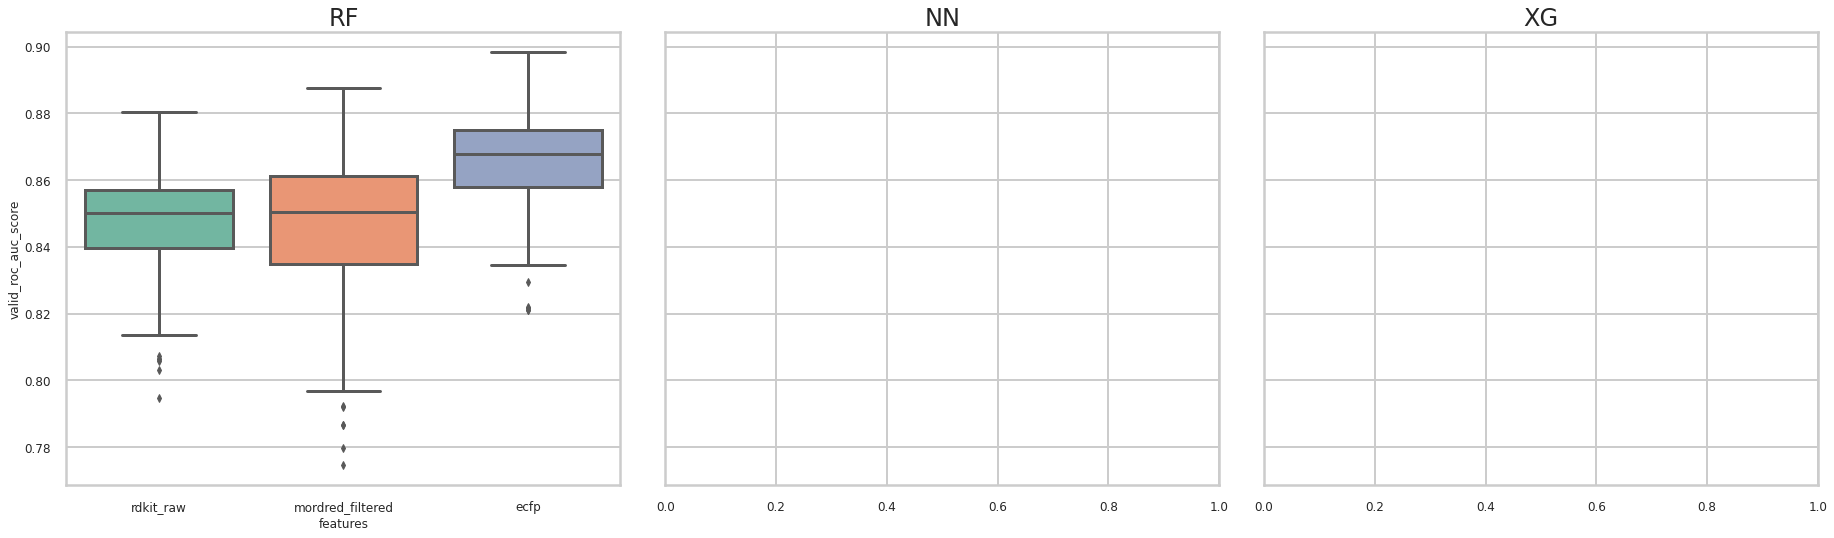

In [ ]:
# which feature set works best for each model type?

fig,ax = plt.subplots(1,3,sharey=True, figsize=(26,8))
plot_df = perf_df[perf_df.model_type=='RF']
sns.boxplot(data=plot_df, x="features", y=f"valid_{scoretype}", width = 0.8, ax=ax[0]);
# plot_df = perf_df[perf_df.model_type=='NN']
# sns.boxplot(data=plot_df, x="features", y=f"valid_{scoretype}", width = 0.8, ax=ax[1]);
# plot_df = perf_df[perf_df.model_type=='xgboost']
# sns.boxplot(data=plot_df, x="features", y=f"valid_{scoretype}", width = 0.8, ax=ax[2]);
ax[0].set_title("RF");
ax[1].set_title("NN");
ax[2].set_title("XG");
plt.tight_layout()

#### Examine the effect of RF hyperparameters on model performance
- any major differences between feature sets?
- did you capture the right range of HPs or do you need to expand / zero in on a particular range?

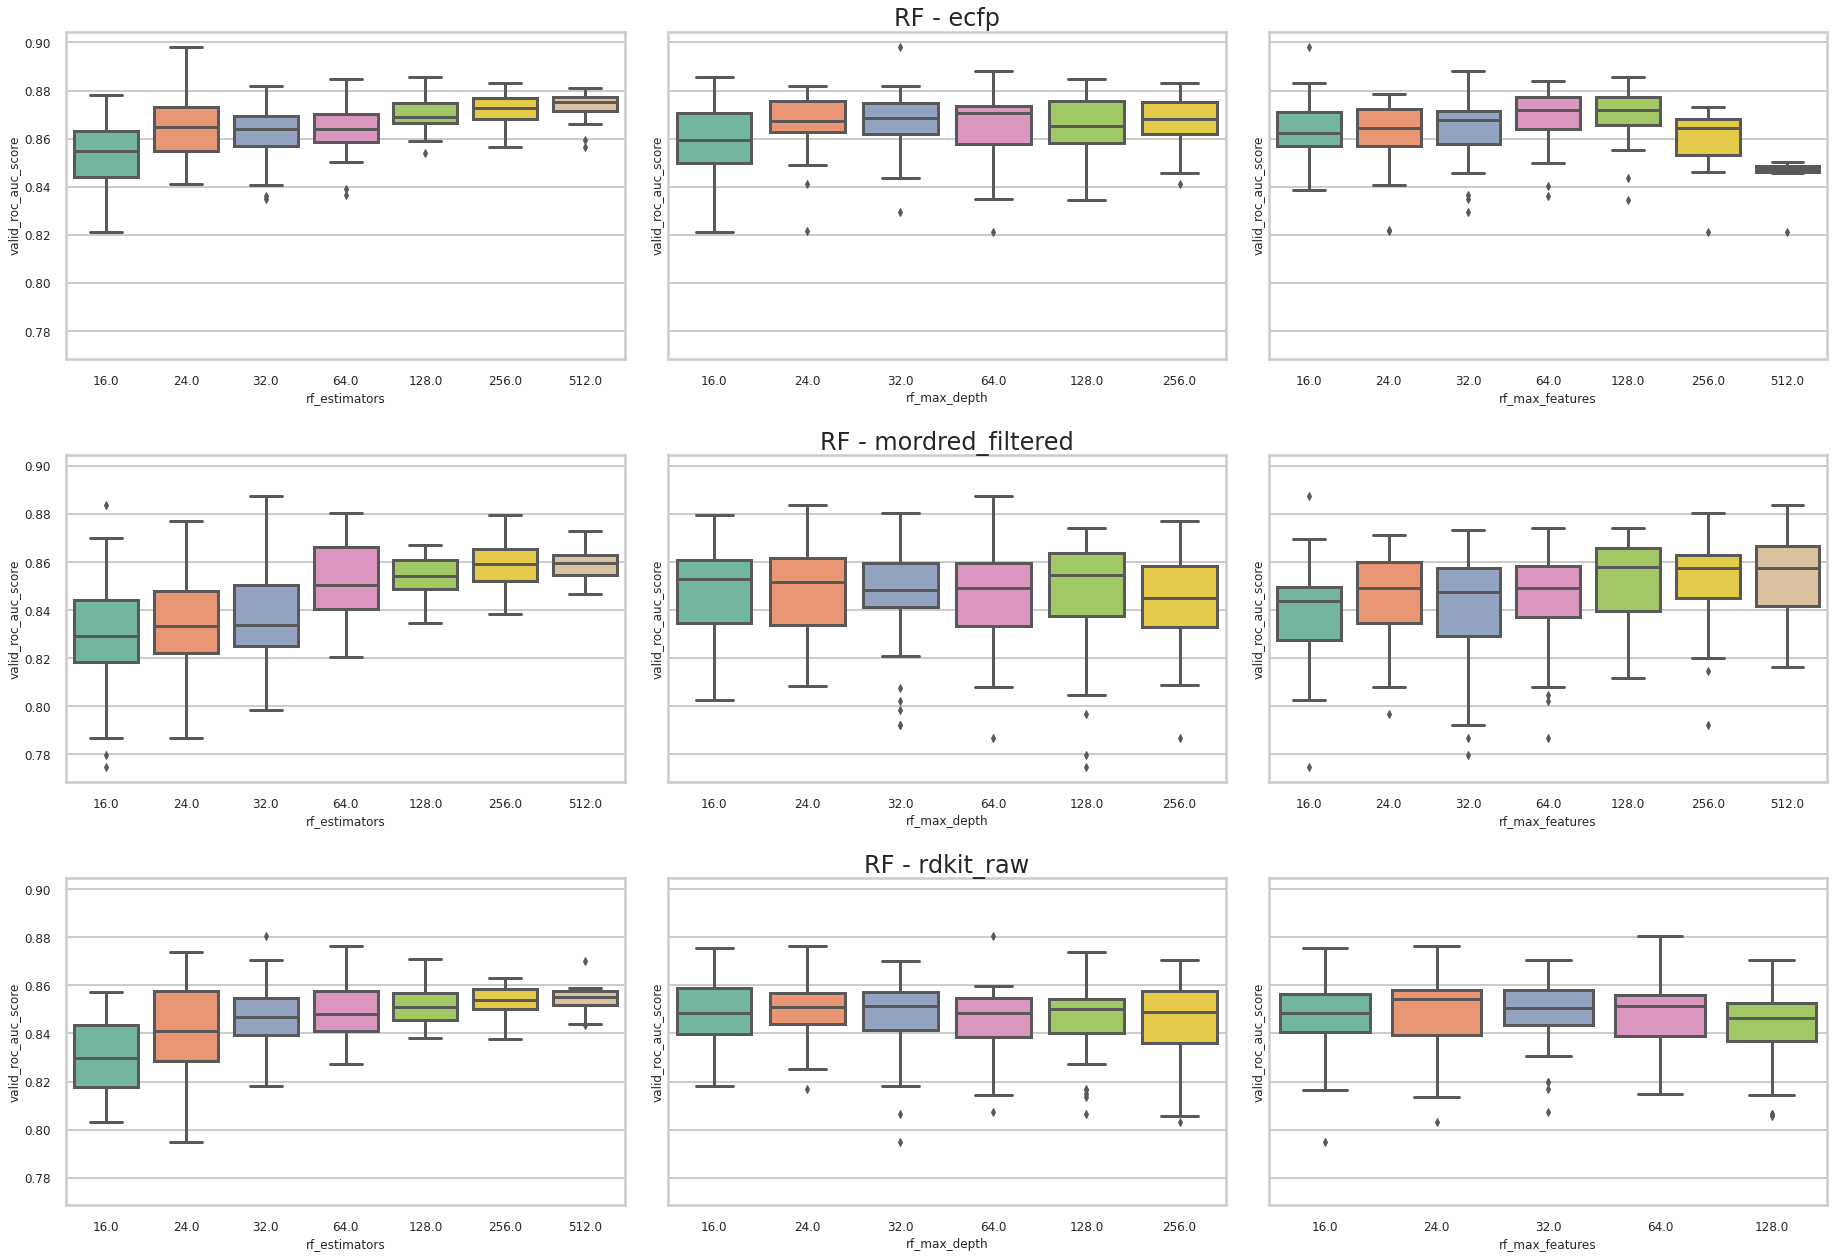

In [ ]:
modtype = 'RF'
feat1 = 'rf_estimators'
feat2 = 'rf_max_depth'
feat3 = 'rf_max_features'
sub_df = perf_df[perf_df.model_type==modtype]

fig, ax = plt.subplots(3,3,sharey=True, figsize=(26,18))
plot_df=sub_df[sub_df.features=='ecfp']
sns.boxplot(data=plot_df, x=feat1, y=f"valid_{scoretype}", ax=ax[0,0])
sns.boxplot(data=plot_df, x=feat2, y=f"valid_{scoretype}", ax=ax[0,1])
ax[0,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.boxplot(data=plot_df, x=feat3, y=f"valid_{scoretype}", ax=ax[0,2])

plot_df=sub_df[sub_df.features=='mordred_filtered']
sns.boxplot(data=plot_df, x=feat1, y=f"valid_{scoretype}", ax=ax[1,0])
sns.boxplot(data=plot_df, x=feat2, y=f"valid_{scoretype}", ax=ax[1,1])
ax[1,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.boxplot(data=plot_df, x=feat3, y=f"valid_{scoretype}", ax=ax[1,2])

plot_df=sub_df[sub_df.features=='rdkit_raw']
sns.boxplot(data=plot_df, x=feat1, y=f"valid_{scoretype}", ax=ax[2,0])
sns.boxplot(data=plot_df, x=feat2, y=f"valid_{scoretype}", ax=ax[2,1])
ax[2,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.boxplot(data=plot_df, x=feat3, y=f"valid_{scoretype}", ax=ax[2,2])
fig.tight_layout();

#### Examine NN hyperparameters
- are training or test sets different?

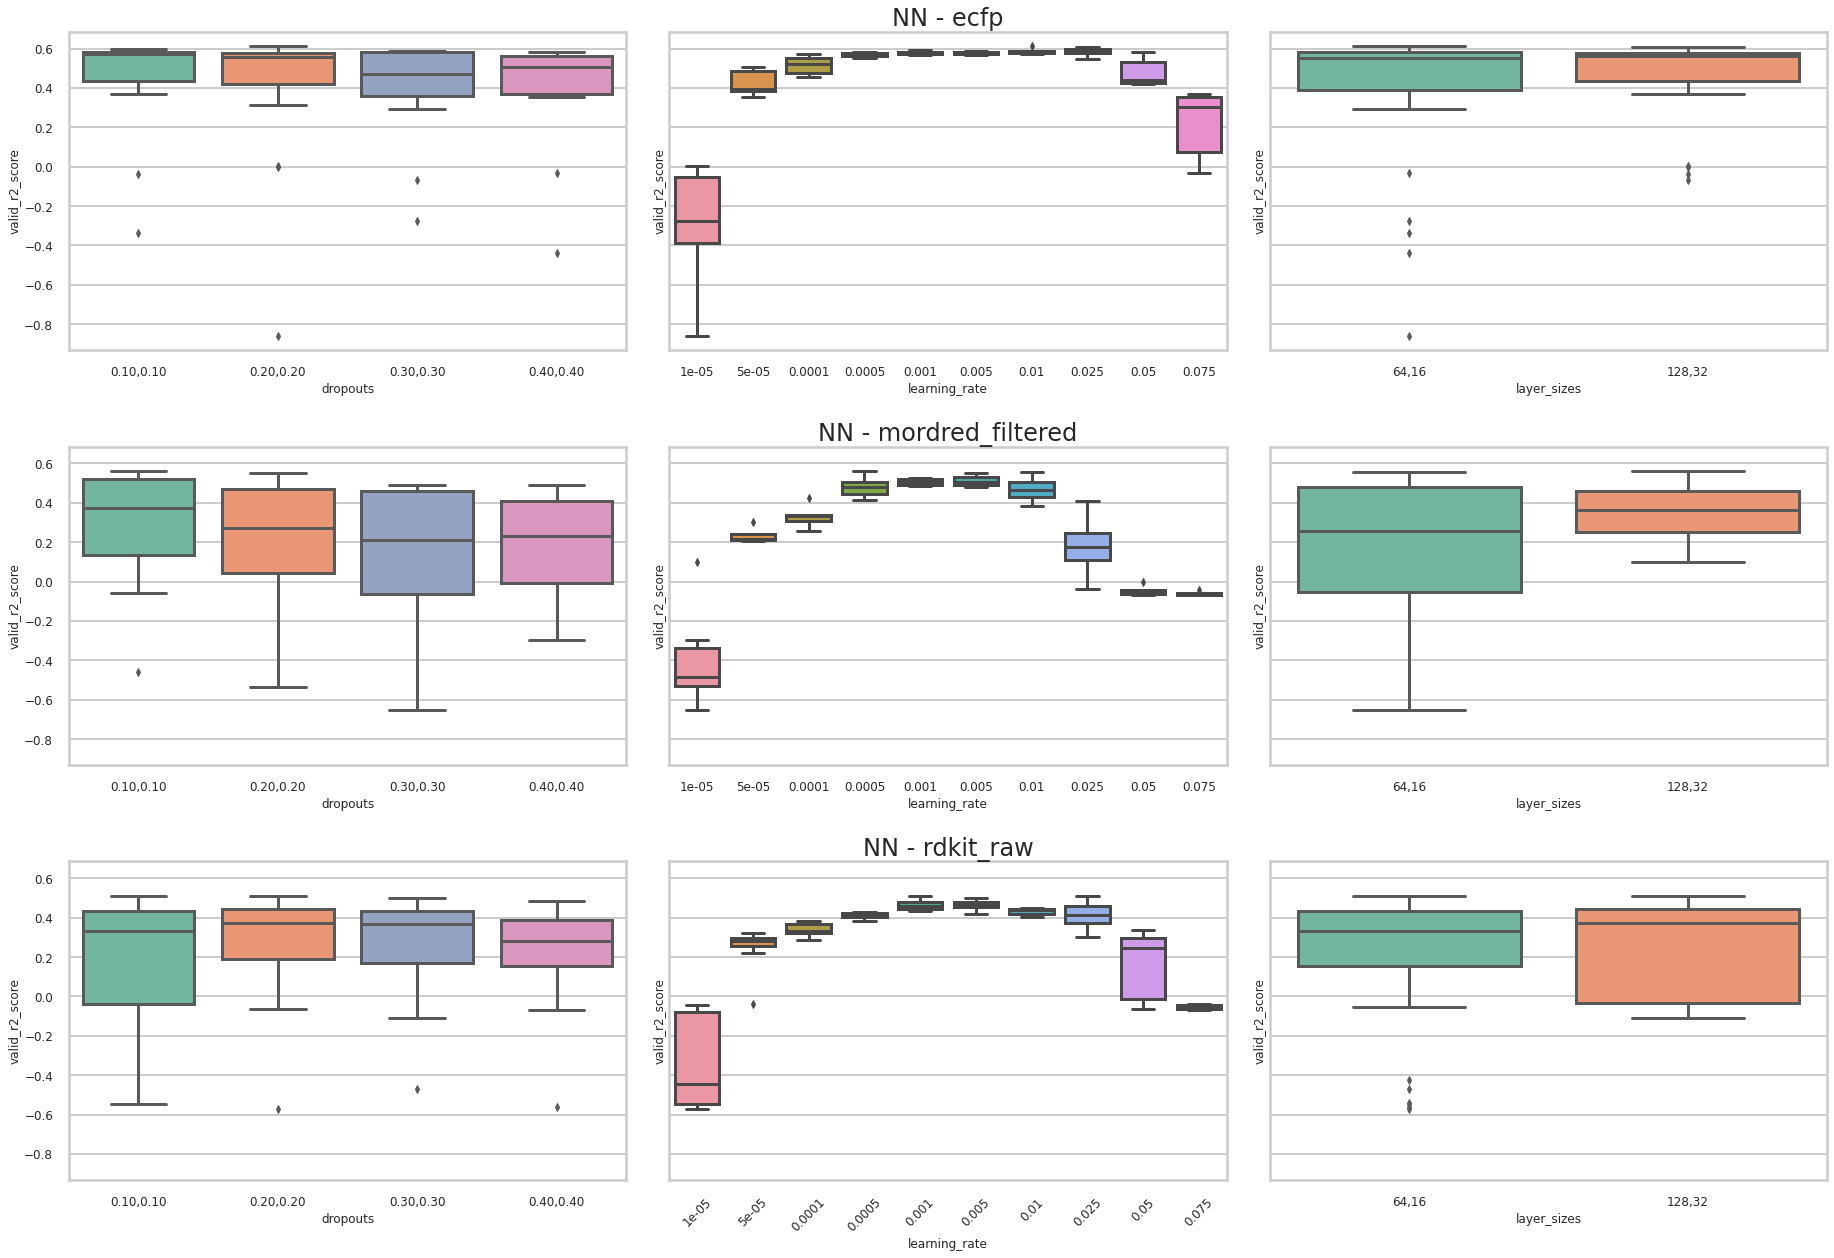

In [ ]:
modtype = 'NN'
feat1 = 'dropouts'
feat2 = 'learning_rate'
feat3 = 'layer_sizes'
sub_df = perf_df[perf_df.model_type==modtype]

fig, ax = plt.subplots(3,3,sharey=True,figsize=(26,18))
plot_df=sub_df[sub_df.features=='ecfp']
sns.boxplot(data=plot_df, x=feat1, y="valid_r2_score", ax=ax[0,0])
sns.boxplot(data=plot_df, x=feat2, y="valid_r2_score", ax=ax[0,1])
ax[0,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.boxplot(data=plot_df, x=feat3, y="valid_r2_score", ax=ax[0,2])

plot_df=sub_df[sub_df.features=='mordred_filtered']
sns.boxplot(data=plot_df, x=feat1, y="valid_r2_score", ax=ax[1,0])
sns.boxplot(data=plot_df, x=feat2, y="valid_r2_score", ax=ax[1,1])
ax[1,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.boxplot(data=plot_df, x=feat3, y="valid_r2_score", ax=ax[1,2])

plot_df=sub_df[sub_df.features=='rdkit_raw']
sns.boxplot(data=plot_df, x=feat1, y="valid_r2_score", ax=ax[2,0])
sns.boxplot(data=plot_df, x=feat2, y="valid_r2_score", ax=ax[2,1]); ax[2,1].tick_params(axis='x', rotation=45);
ax[2,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.boxplot(data=plot_df, x=feat3, y="valid_r2_score", ax=ax[2,2])
fig.tight_layout();

#### Examine XGBoost hyperparameters
- what is the third graph?
- how do R2 vs RMS scores look?


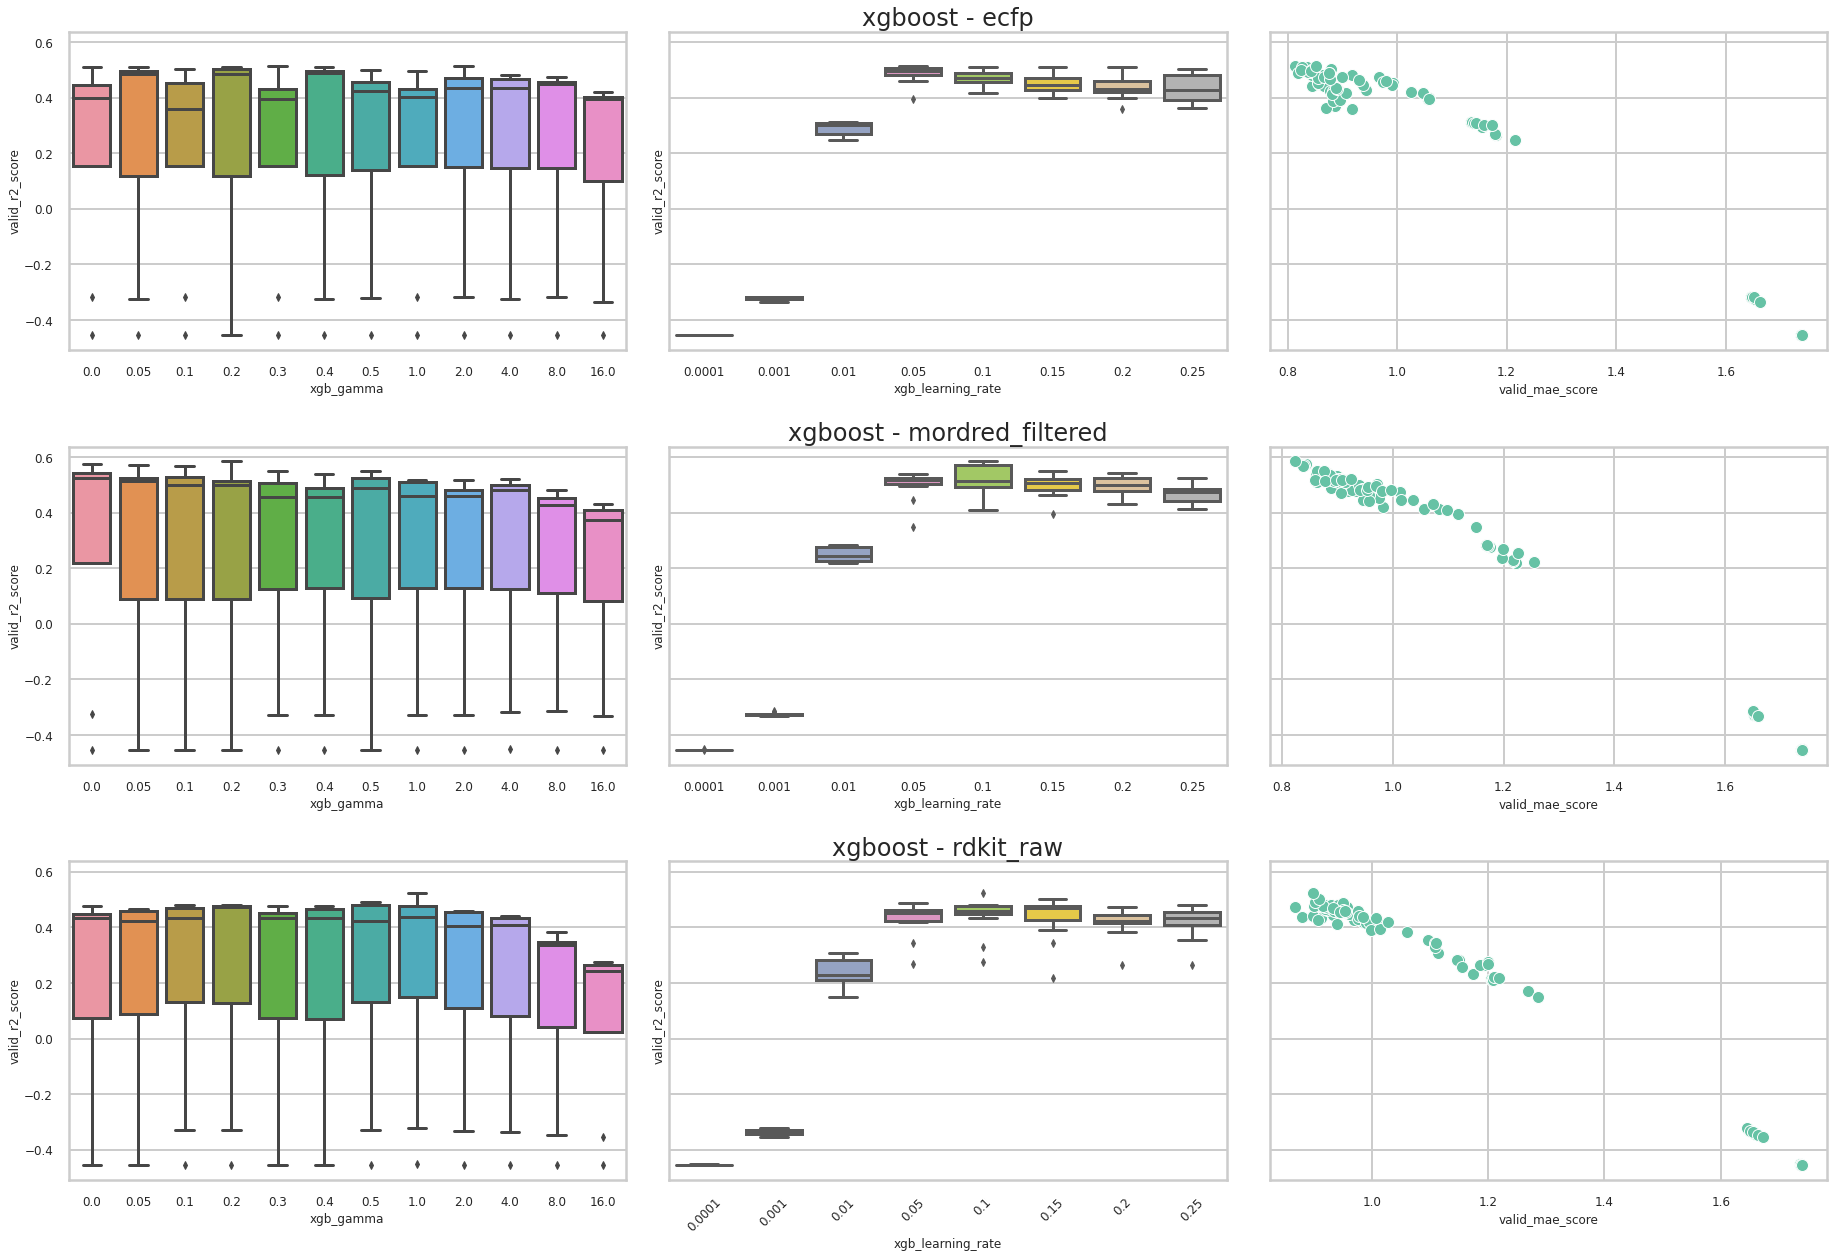

In [ ]:
modtype = 'xgboost'
feat1 = 'xgb_gamma'
feat2 = 'xgb_learning_rate'
feat3 = 'valid_mae_score'
sub_df = perf_df[perf_df.model_type==modtype]

fig, ax = plt.subplots(3,3,sharey=True, figsize=(26,18))
plot_df=sub_df[sub_df.features=='ecfp']
sns.boxplot(data=plot_df, x=feat1, y="valid_r2_score", ax=ax[0,0])
sns.boxplot(data=plot_df, x=feat2, y="valid_r2_score", ax=ax[0,1])
ax[0,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.scatterplot(data=plot_df, x=feat3, y="valid_r2_score", ax=ax[0,2])

plot_df=sub_df[sub_df.features=='mordred_filtered']
sns.boxplot(data=plot_df, x=feat1, y="valid_r2_score", ax=ax[1,0])
sns.boxplot(data=plot_df, x=feat2, y="valid_r2_score", ax=ax[1,1])
ax[1,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.scatterplot(data=plot_df, x=feat3, y="valid_r2_score", ax=ax[1,2])

plot_df=sub_df[sub_df.features=='rdkit_raw']
sns.boxplot(data=plot_df, x=feat1, y="valid_r2_score", ax=ax[2,0])
sns.boxplot(data=plot_df, x=feat2, y="valid_r2_score", ax=ax[2,1]); ax[2,1].tick_params(axis='x', rotation=45);
ax[2,1].set_title(f"{modtype} - {plot_df.features.iloc[0]}")
sns.scatterplot(data=plot_df, x=feat3, y="valid_r2_score", ax=ax[2,2])
fig.tight_layout();

# Choose best model and examine predictions (regression models)
Metrics for regression models:
- RMSE
- MAE
- R^2

#### select models and generate predictions
- predict on the same dataset as the model was trained on first

In [ ]:
# best models per metric
top_r2_model = perf_df[perf_df.valid_r2_score==perf_df.valid_r2_score.max()]    # maximize pearson correlation
top_rms_model = perf_df[perf_df.valid_rms_score==perf_df.valid_rms_score.min()] # minimize root mean squared error
top_mae_model = perf_df[perf_df.valid_mae_score==perf_df.valid_mae_score.min()] # minimize mean absolute error
display(top_r2_model, top_rms_model, top_mae_model)
# note: only two different model_uuids here; note featurizer & featurizer types

,collection,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
1240,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,44080ec3-f88a-469e-ae3d-7a0c31d4a768,1.617830e+09,NN,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,"64,16","0.20,0.20",0.01,38.0,70.0,NaN,NaN,NaN,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,VALUE_NUM_mean,801,0.917906,0.346156,0.457862,100,0.61227,0.783147,1.090699,101,0.636958,0.731418,1.04145


,collection,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
1240,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,44080ec3-f88a-469e-ae3d-7a0c31d4a768,1.617830e+09,NN,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,"64,16","0.20,0.20",0.01,38.0,70.0,NaN,NaN,NaN,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,VALUE_NUM_mean,801,0.917906,0.346156,0.457862,100,0.61227,0.783147,1.090699,101,0.636958,0.731418,1.04145


,collection,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
250,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,fe2edb07-def9-4e56-9745-276a39eafcd4,1.617742e+09,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,128.0,24.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,VALUE_NUM_mean,801,0.947466,0.244521,0.366269,100,0.575538,0.758454,1.141195,101,0.587288,0.81692,1.110412


In [ ]:
from atomsci.ddm.pipeline import predict_from_model as pfm

In [ ]:
# create strings that are paths to the best models based on their model_uuids
rms_model_path = top_rms_model.collection.values[0]+'/'+top_rms_model.dataset_key.values[0].split('/')[-1].strip('.csv')+'_model_'+top_rms_model.model_uuid.values[0]+'.tar.gz'
mae_model_path = top_mae_model.collection.values[0]+'/'+top_mae_model.dataset_key.values[0].split('/')[-1].strip('.csv')+'_model_'+top_mae_model.model_uuid.values[0]+'.tar.gz'
split_path = f'/content/drive/MyDrive/Columbia_E4511/HTR3A_curated_train_valid_test_scaffold_{top_rms_model.split_uuid.values[0]}.csv'
split_df=pd.read_csv(split_path)

In [ ]:
# check what features the models used - get paths to the mordred or rdkit features as needed
mordred_input_df = pd.read_csv('/content/drive/MyDrive/Columbia_E4511/scaled_descriptors/HTR3A_curated_with_mordred_filtered_descriptors.csv')
mordred_input_df = mordred_input_df[~mordred_input_df.VALUE_NUM_mean.isna()]
mordred_input_df = mordred_input_df[mordred_input_df.VALUE_NUM_mean>2]
ecfp_input_df = h1
display(mordred_input_df.head(), ecfp_input_df.head())

,compound_id,base_rdkit_smiles,VALUE_NUM_mean,AATS0Z,AATS0are,AATS0d,AATS0dv,AATS0i,AATS0m,AATS0p,AATS0pe,AATS0s,AATS0se,AATS0v,AATS1Z,AATS1are,AATS1d,AATS1dv,AATS1i,AATS1m,AATS1p,AATS1pe,AATS1s,AATS1se,AATS1v,AATS2Z,AATS2are,AATS2d,AATS2dv,AATS2i,AATS2m,AATS2p,AATS2pe,AATS2s,AATS2se,AATS2v,AATS3Z,AATS3are,AATS3d,AATS3dv,...,nFaRing,nG12AHRing,nG12ARing,nG12FAHRing,nG12FARing,nG12FHRing,nG12FRing,nG12FaHRing,nG12FaRing,nG12HRing,nG12Ring,nG12aHRing,nG12aRing,nH,nHBAcc,nHBDon,nHRing,nHeavyAtom,nHetero,nI,nN,nO,nP,nRing,nRot,nS,nSpiro,nX,naHRing,naRing,piPC1,piPC10,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9
0,CHEMBL1278087,Cc1cccc2c(=O)n(N)c(CCCCN3CCN(c4ccc5ccccc5n4)CC...,7.807917,21.015873,5.976181,3.301587,6.539683,163.445627,82.769736,1.488143,6.056321,3.257496,7.494744,216.194089,24.044776,6.291536,3.985075,6.731343,148.171151,90.933259,1.811705,6.433599,2.878524,7.683097,261.576337,20.000000,6.191368,3.613445,5.361345,156.509892,74.110432,1.557124,6.297402,2.641923,7.645059,218.973078,16.981250,6.063455,3.106250,4.031250,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,7.0,1.0,3.0,33.0,7.0,0.0,6.0,1.0,0.0,5.0,6.0,0.0,0.0,0.0,2.0,4.0,3.912023,7.474964,4.564348,5.219004,5.826369,6.430626,6.733513,7.085797,7.360059,7.678576
1,CHEMBL224227,CC1CCCCN1CCCNC(=O)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c...,4.937028,25.903226,6.114008,3.241935,6.832338,162.934586,103.959025,1.518359,6.215731,4.392111,7.682027,219.608889,25.138462,6.301277,3.953846,6.524786,147.103070,95.593890,1.829493,6.458385,2.885787,7.722713,264.145862,21.068376,6.214367,3.487179,5.150997,155.371815,78.549964,1.567121,6.332748,2.821172,7.696088,218.350104,17.098160,6.035454,2.907975,3.758691,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,5.0,2.0,2.0,33.0,8.0,0.0,4.0,3.0,0.0,4.0,7.0,0.0,0.0,1.0,1.0,3.0,3.881564,8.074721,4.499810,5.090678,5.681025,6.279459,6.678146,7.082890,7.501155,7.925488
2,CHEMBL224008,COc1cccc(Cn2c(=O)[nH]c3cc(C(=O)NCCN4CCCCC4)ccc...,5.569091,22.400000,6.203660,3.233333,7.500000,163.458737,88.324082,1.446593,6.264680,4.666204,7.721713,214.559505,24.603175,6.381079,3.920635,6.936508,147.867548,93.198501,1.766092,6.518508,3.055556,7.782589,259.542440,20.250000,6.320178,3.500000,5.553571,157.000300,74.895911,1.505962,6.412741,2.999752,7.785563,214.408508,16.973333,6.112933,3.000000,4.326667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,6.0,2.0,2.0,32.0,8.0,0.0,4.0,4.0,0.0,4.0,7.0,0.0,0.0,0.0,1.0,3.0,3.860730,8.108643,4.477337,5.084505,5.690359,6.280396,6.697381,7.111385,7.497991,7.955346
3,CHEMBL4060728,CN1C(Nc2nc3ccccc3s2)=NCC12CN1CCC2CC1,7.366532,25.772727,5.931093,3.568182,6.055556,163.688747,101.878437,1.618368,6.023793,2.309579,7.477921,219.679411,26.895833,6.298000,4.354167,6.194444,148.034006,102.514513,1.895626,6.450052,2.500450,7.711390,265.521215,23.488889,6.236780,4.011111,4.796296,157.491949,88.278886,1.652612,6.349520,2.279904,7.708772,226.200984,17.760331,6.015189,3.280992,3.146006,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,6.0,1.0,5.0,23.0,6.0,0.0,5.0,0.0,0.0,6.0,1.0,1.0,1.0,0.0,1.0,2.0,3.526361,7.102634,4.131159,4.708403,5.289844,5.721131,5.981690,6.381274,6.742821,6.733002
4,CHEMBL4093500,c1ccc(-c2cnc(NC3=NC[C@@]4(CN5CCC4CC5)O3)cn2)cc1,4.000000,22.043478,6.081837,3.543478,7.130435,163.782936,86.941389,1.500417,6.157154,2.748943,7.580814,220.272639,25.220000,6.373580,4.280000,7.160000,147.914601,95.988672,1.810249,6.514880,2.818056,7.756510,265.890843,21.406593,6.348020,3.901099,5.692308,156.305118,79.702030,1.571915,6.448867,2.702686,7.780747,225.211337,16.201613,6.134039,3.161290,3.870968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,6.0,1.0,5.0,25.0,6.0,0.0,5.0,1.0,0.0,6.0,2.0,0.0,1.0,0.0,1.0,2.0,3.610918,7.144136,4.158883,4.663439,5.190175,5.684430,5.810954,6.210600,6.542472,6.831701


,compound_id,base_rdkit_smiles,relation,pXC50,active,datasource,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL3980976,Cc1c(C(=O)OC2CC3CCC(C2)N3C)c2ccccc2n1CC(F)F,NaN,8.501689,1,chembl,8.501689,NaN,0.0,0
1,CHEMBL459900,CN1C(=O)[C@@H](CN2CCCCC2)C[C@H]1C#Cc1ccc2occc2c1,NaN,4.000000,0,chembl,4.000000,0.0,0.0,0
2,CHEMBL4098776,c1ccc(-c2ccnc(NC3=NC[C@@]4(CN5CCC4CC5)O3)n2)cc1,NaN,8.420216,1,chembl,8.420216,NaN,0.0,0
3,CHEMBL3966678,CN1C2CCC1CC(NC(=O)c1cn(CC(F)F)c3ncccc13)C2,NaN,8.913640,1,chembl,8.913640,NaN,0.0,0
4,CHEMBL3935292,CN1C2COCC1CC(OC(=O)c1cn(CCF)c3ncccc13)C2,NaN,9.221849,1,chembl,9.221849,NaN,0.0,0


In [ ]:
# predict using your best models
# if the models use ECFP (or graphconv), is_featurized = False and the input df is equivalent to the original data df
# if the models use rdkit or mordred, is_featurized = True and the input df is the featurized df from the scaled descriptors folder
# if you use rdkit or mordred and leave featurized=False then the smiles will be re-featurized and it can take a very long time
rms_pred = predict_from_model_file(model_path= rms_model_path, input_df=ecfp_input_df, id_col='compound_id', smiles_col = 'base_rdkit_smiles', 
                            response_col = 'VALUE_NUM_mean', is_featurized = False, dont_standardize=True)
mae_pred = predict_from_model_file(model_path= mae_model_path, input_df=ecfp_input_df, id_col='compound_id', smiles_col = 'base_rdkit_smiles', 
                            response_col = 'VALUE_NUM_mean', is_featurized = False, dont_standardize=True)

2021-04-09 18:51:47,257 ['time_generated', 'best_epoch', 'time_built', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored


Featurization = DynamicFeaturization with ecfp features
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-04-09 18:51:47,396 From /tensorflow-1.15.2/python3.7/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-04-09 18:51:47,434 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a4e7f46d0>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 18:51:47,488 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a4e7f4d90>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 18:51:47,569 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a4e3a53d0>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 18:51:47,616 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a4e5b4a90>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 18:51:47,659 From /usr/local/lib/python3.7/site-packages/deepchem/models/keras_model.py:169: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2021-04-09 18:51:47,670 From /usr/local/lib/python3.7/site-packages/deepchem/models/optimizers.py:76: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



2021-04-09 18:51:47,676 From /usr/local/lib/python3.7/site-packages/deepchem/models/keras_model.py:258: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2021-04-09 18:51:47,679 From /usr/local/lib/python3.7/site-packages/deepchem/models/keras_model.py:260: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



number of features: 1024
TIMING: dataset construction took 0.067 s
Loading dataset from disk.


2021-04-09 18:51:52,834 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a4e3a53d0>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 18:51:52,870 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a4e5b4a90>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 18:51:53,098 Unresolved object in checkpoint: (root).optimizer.beta1_power


2021-04-09 18:51:53,101 Unresolved object in checkpoint: (root).optimizer.beta2_power


2021-04-09 18:51:53,104 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-0.kernel


2021-04-09 18:51:53,107 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-0.bias


2021-04-09 18:51:53,118 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-1.kernel


2021-04-09 18:51:53,123 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-1.bias


2021-04-09 18:51:53,125 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-2.kernel


2021-04-09 18:51:53,128 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-2.bias


2021-04-09 18:51:53,132 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-0.kernel


2021-04-09 18:51:53,135 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-0.bias


2021-04-09 18:51:53,138 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-1.kernel


2021-04-09 18:51:53,140 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-1.bias


2021-04-09 18:51:53,142 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-2.kernel


2021-04-09 18:51:53,145 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-2.bias


2021-04-09 18:51:53,147 A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#loading_mechanics for details.


Featurization = DynamicFeaturization with ecfp features
number of features: 1024
TIMING: dataset construction took 0.064 s
Loading dataset from disk.


In [ ]:
# merge with the split df so you know which molecule was in each subset (or if k-fold x-val, training(train+valid) and test subsets only)
# create 'prediction_error' column as diff btw real and pred vals
rms_pred = pd.merge(rms_pred, split_df, left_on='compound_id', right_on='cmpd_id')
rms_pred['pred_err'] = abs(rms_pred.VALUE_NUM_mean_actual - rms_pred.VALUE_NUM_mean_pred)
rms_pred=rms_pred.sort_values('pred_err')
mae_pred = pd.merge(mae_pred, split_df, left_on='compound_id', right_on='cmpd_id')
mae_pred['pred_err'] = abs(mae_pred.VALUE_NUM_mean_actual - mae_pred.VALUE_NUM_mean_pred)
mae_pred=mae_pred.sort_values('pred_err')

In [ ]:
display(rms_pred.head(), mae_pred.head())

,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred,cmpd_id,subset,fold,pred_err
461,CHEMBL3084706,O=C(O[C@@H]1C[C@@H]2CC[C@H](C1)N2)c1cc2ccccc2[...,7.490000,7.490840,CHEMBL3084706,train,0,0.000840
62,53237429,COc1ccc(Sc2ccc(C)cc2N2CCNCC2)cc1,6.721250,6.722243,53237429,train,0,0.000993
649,CHEMBL3934011,CN1C2COCC1CC(OC(=O)c1cn(-c3cnc(F)cn3)c3ccccc13)C2,8.903090,8.904427,CHEMBL3934011,train,0,0.001337
667,CHEMBL3942973,CN1C2COCC1CC(OC(=O)c1cn(-c3ccsn3)c3ccccc13)C2,8.790485,8.792762,CHEMBL3942973,train,0,0.002277
183,CHEMBL1242950,CCCCC1CCN(CCCC(=O)c2ccccc2C)CC1,6.000000,6.003902,CHEMBL1242950,train,0,0.003902


,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred,VALUE_NUM_mean_std,cmpd_id,subset,fold,pred_err
423,CHEMBL2402903,CC(C)c1nc2cccc(C(=O)NCC3CCN(CC4CCN(S(C)(=O)=O)...,4.000000,4.000000,0.000000e+00,CHEMBL2402903,train,0,0.000000e+00
317,CHEMBL2086582,COc1ccc(-c2cc(NC(=O)CCCCN3CCCN(C(C)=O)CC3)[nH]...,4.522879,4.522879,8.599751e-16,CHEMBL2086582,train,0,8.881784e-16
156,CHEMBL1083787,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)cc2)nc1,4.522879,4.522879,8.599751e-16,CHEMBL1083787,train,0,8.881784e-16
324,CHEMBL2087456,COc1ccc(-c2cc(NC(=O)CCCCN3CCCCCC3)[nH]n2)cc1,4.522879,4.522879,8.599751e-16,CHEMBL2087456,train,0,8.881784e-16
322,CHEMBL2087448,O=C(CCCCN1CCCCC1)Nc1cc(-c2ccc(Br)cc2)n[nH]1,4.522879,4.522879,8.599751e-16,CHEMBL2087448,train,0,8.881784e-16


#### Plot predicted vs actual values for each model
- What do you notice about the predictions? Do they cut off at a certain point?
- What do you notice about train/valid/test splits?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


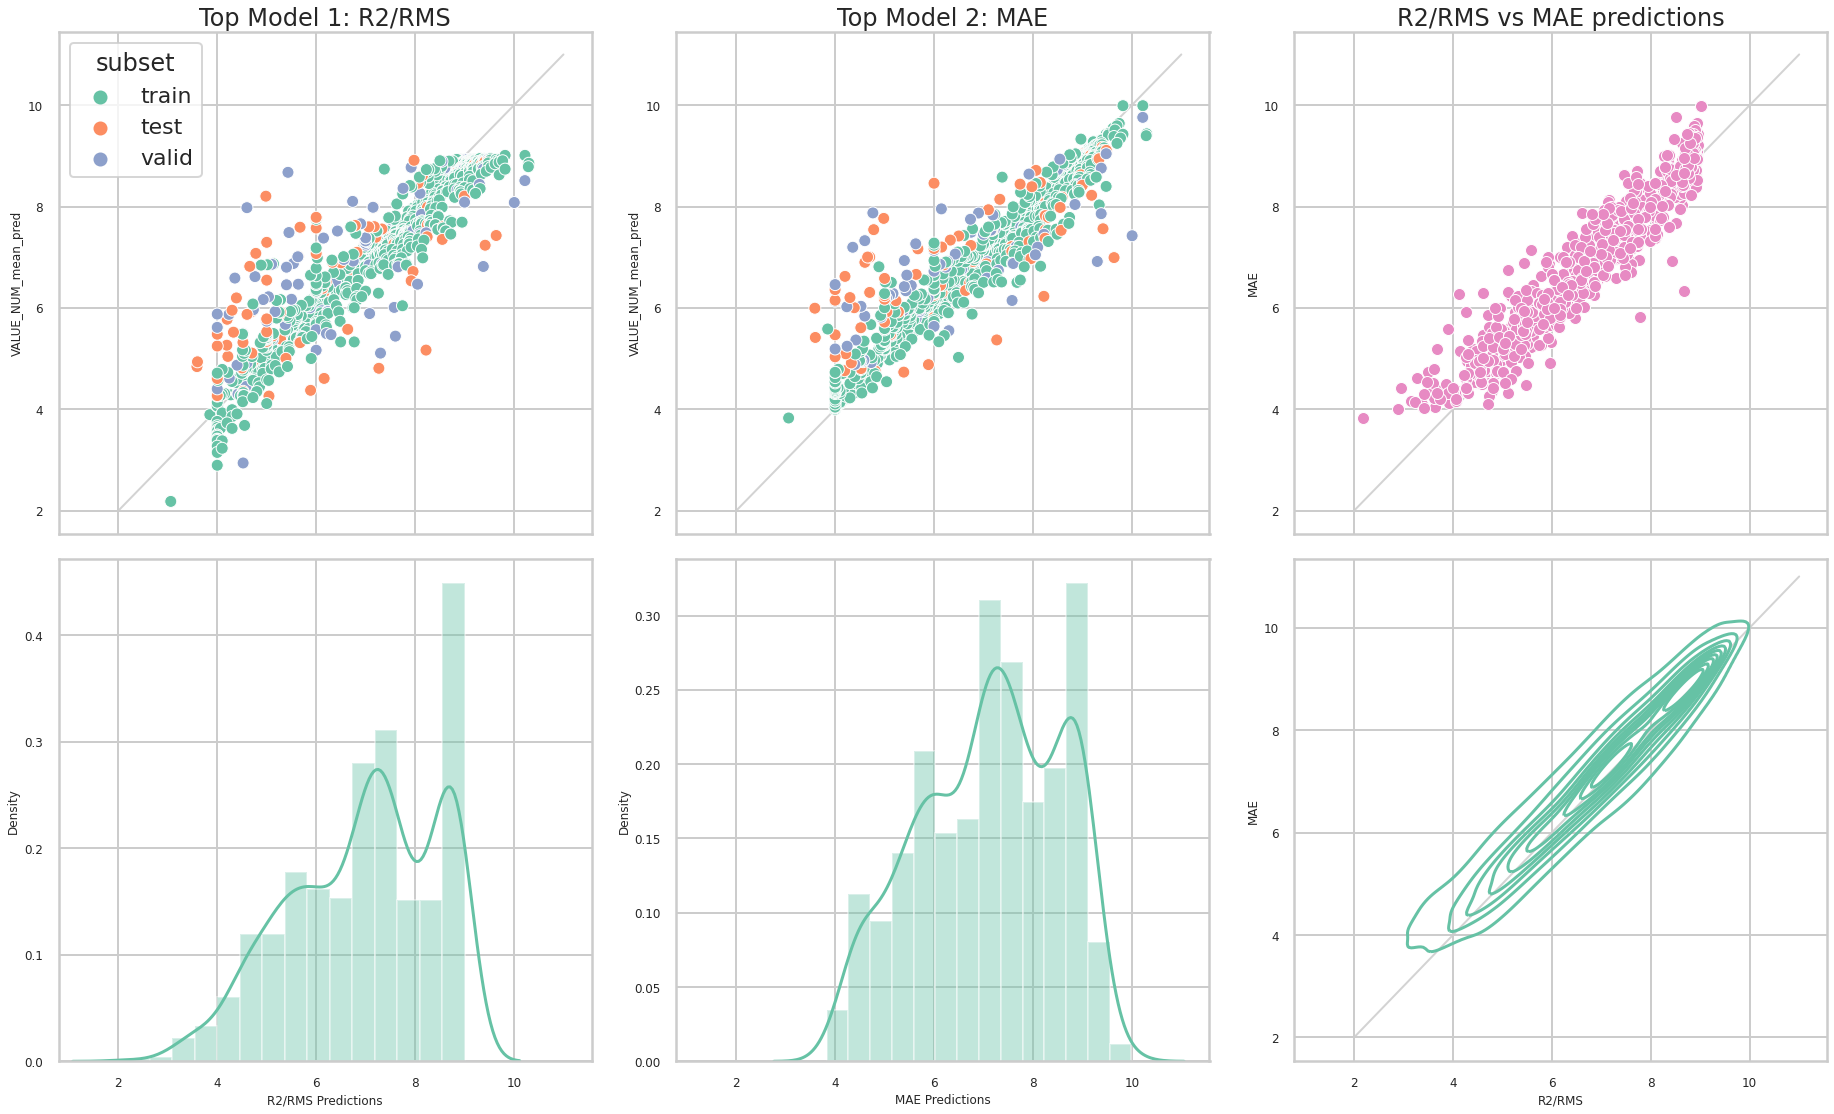

In [ ]:
response_col = 'VALUE_NUM_mean'
fig, ax = plt.subplots(2,3,sharex=True, figsize=(26,16))

sns.scatterplot(data=rms_pred, x=f'{response_col}_actual', y=f'{response_col}_pred', ax=ax[0,0], hue = 'subset')
sns.scatterplot(data=mae_pred, x=f'{response_col}_actual', y=f'{response_col}_pred', ax=ax[0,1], hue = 'subset', legend=False)
sns.scatterplot(x=rms_pred[f'{response_col}_pred'], y=mae_pred[f'{response_col}_pred'], ax=ax[0,2], color=pal[3])
ax[0,2].set_ylabel('MAE')

ax[0,0].plot([2, 11], [2, 11], linewidth=2, color='lightgrey', zorder=0)
ax[0,1].plot([2, 11], [2, 11], linewidth=2, color='lightgrey', zorder=0)
ax[0,2].plot([2, 11], [2, 11], linewidth=2, color='lightgrey', zorder=0)
ax[1,2].plot([2, 11], [2, 11], linewidth=2, color='lightgrey', zorder=0)

ax[0,0].set_title('Top Model 1: R2/RMS')
ax[0,1].set_title('Top Model 2: MAE')
ax[0,2].set_title('R2/RMS vs MAE predictions')

sns.distplot(x=rms_pred[f'{response_col}_pred'],ax=ax[1,0], axlabel = 'R2/RMS Predictions');
sns.distplot(x=mae_pred[f'{response_col}_pred'],ax=ax[1,1], axlabel = 'MAE Predictions');
sns.kdeplot(x=rms_pred[f'{response_col}_pred'], y=mae_pred[f'{response_col}_pred'], ax=ax[1,2])
ax[1,2].set_ylabel('MAE')
ax[1,2].set_xlabel('R2/RMS')

plt.tight_layout()

#### Look at uncertainty of predictions
- for this one, choose an RF model you trained with uncertainty=True
- Does uncertainty correlate with anything? such as magnitude of prediction, or prediction error?

In [ ]:
import math
from matplotlib import cm

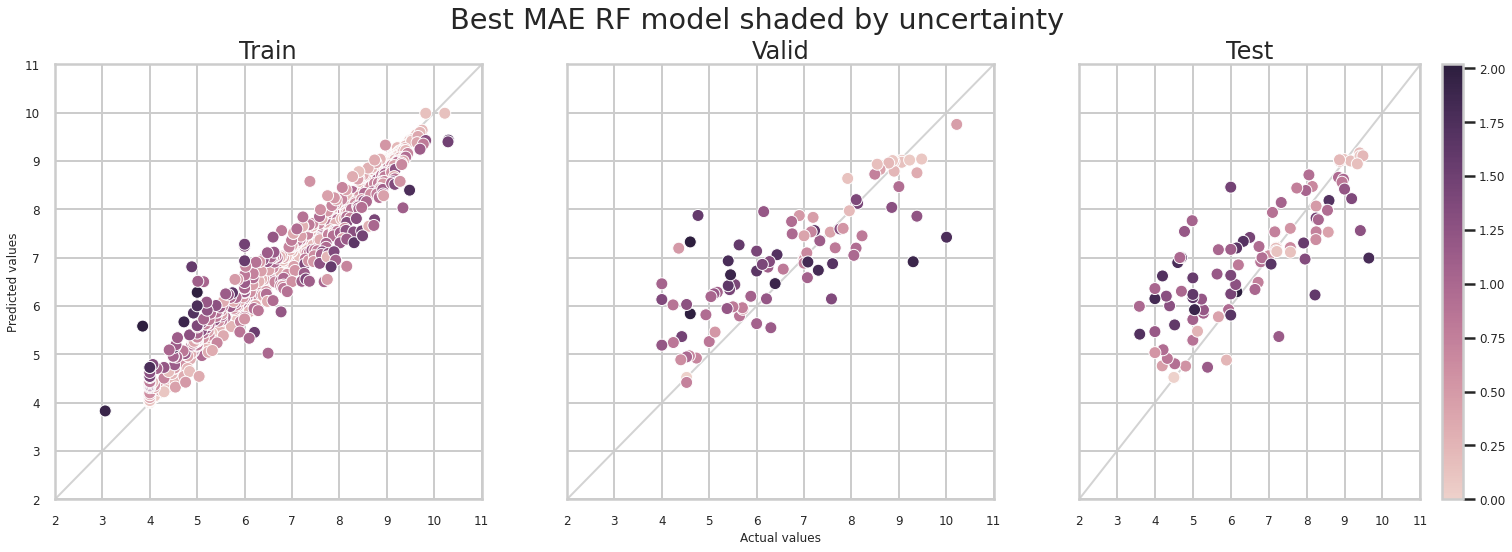

In [ ]:
pred_df=mae_pred
hi = 11; lo=2

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(26,8))
sns.scatterplot(x=f'{response_col}_actual', y=f'{response_col}_pred', hue=f'{response_col}_std', data=pred_df[pred_df['subset']=="train"], legend=False, ax=ax[0])
ax[0].set_title("Train")
ax[0].set_xlabel("")
ax[0].set_ylabel(f"Predicted values")

sns.scatterplot(x=f'{response_col}_actual', y=f'{response_col}_pred', hue=f'{response_col}_std', data=pred_df[pred_df['subset']=="valid"], legend=False, ax=ax[1])
ax[1].set_title("Valid")
ax[1].set_xlabel(f"Actual values")

sns.scatterplot(x=f'{response_col}_actual', y=f'{response_col}_pred', hue=f'{response_col}_std', data=pred_df[pred_df['subset']=="test"], legend=False, ax=ax[2])
ax[2].set_title("Test");
ax[2].set_xlabel("")

plt.xlim(lo,hi)
plt.ylim(1,math.ceil(pred_df[f'{response_col}_pred'].max()))
plt.ylim(lo,hi)

ax[0].plot([lo, hi], [lo, hi], linewidth=2, color='lightgrey', zorder=0)
ax[1].plot([lo, hi], [lo, hi], linewidth=2, color='lightgrey', zorder=0)
ax[2].plot([lo, hi], [lo, hi], linewidth=2, color='lightgrey', zorder=0)

# color bar
norm = plt.Normalize(pred_df[f'{response_col}_std'].min(), pred_df[f'{response_col}_std'].max())
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
ax[2].figure.colorbar(sm)

fig.suptitle(f"Best MAE RF model shaded by uncertainty");

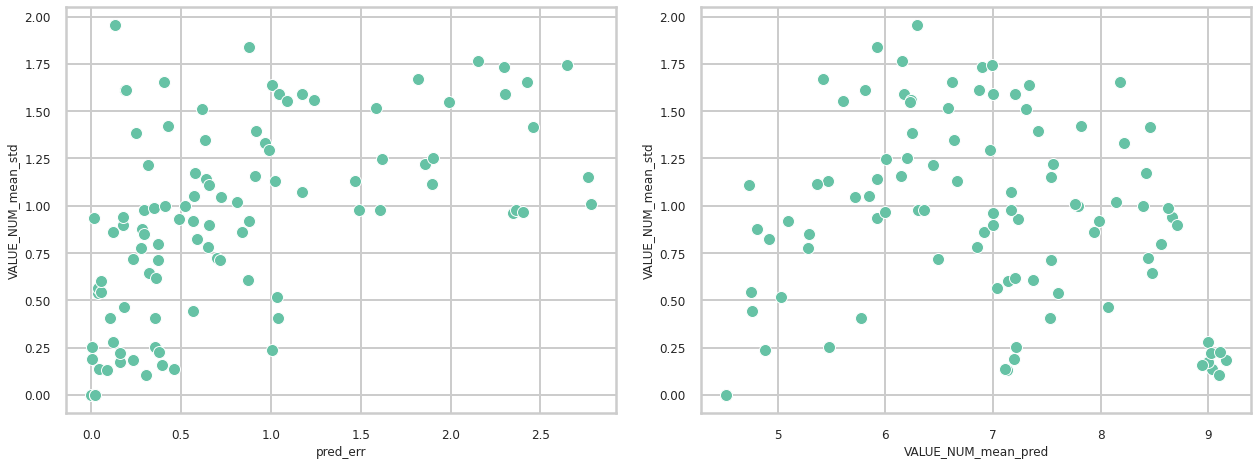

In [ ]:
subset='test'
pred_df=mae_pred[mae_pred.subset==subset]
fig, ax = plt.subplots(1,2,figsize=(18,7))
sns.scatterplot(x='pred_err', y=f'{response_col}_std',  data=pred_df, ax=ax[0])
sns.scatterplot(x=f'{response_col}_pred', y=f'{response_col}_std',  data=pred_df, ax=ax[1]);
plt.tight_layout()

#### Uncertainty calibration curve
Extra credit: interpret this plot according to writeup in ampl paper

[9. 8. 8. 9. 8. 8. 9. 8. 9. 8. 8. 8.]


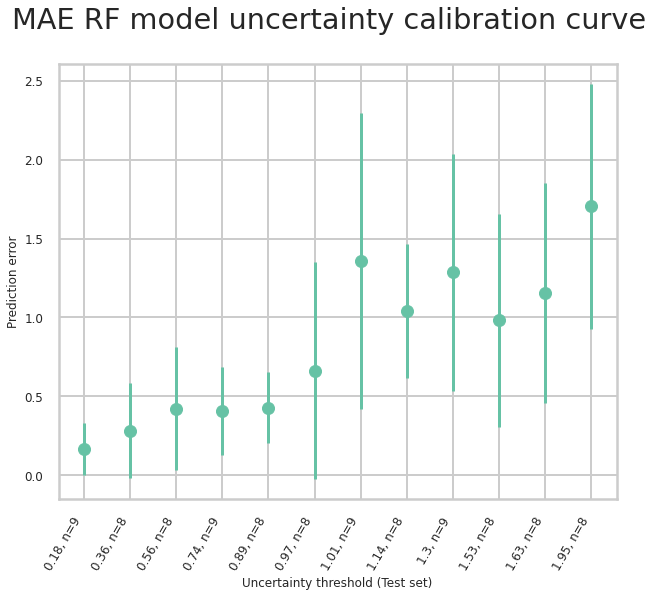

In [ ]:
from scipy import stats
pred_df=mae_pred
sub_df=pred_df[pred_df['subset']=="test"]
# divide test set into equal bins based on uncertainty values
qbins=pd.qcut(sub_df[f'{response_col}_std'], q=12, duplicates='drop')
qbins=pd.DataFrame({'intervals': qbins.cat.categories, 'left': qbins.cat.categories.left, 'right': qbins.cat.categories.right})
qbins=pd.concat([qbins, pd.DataFrame({'intervals': [np.nan], 'left': [qbins.right.max()], 'right': [np.nan]})])
# for each bin, calculate the average + stdev of prediction errors
bin_means, bin_edges, binnumber = stats.binned_statistic(sub_df[f'{response_col}_std'], sub_df.pred_err , 'mean', bins=qbins.left)
bin_stds, bin_edges, binnumber = stats.binned_statistic(sub_df[f'{response_col}_std'], sub_df.pred_err , 'std', bins=qbins.left)
bin_counts, bin_edges, binnumber = stats.binned_statistic(sub_df[f'{response_col}_std'], sub_df.pred_err ,'count', bins=qbins.left)

x = pd.Series(np.around(bin_edges[1:],2).astype(str))
y = bin_means
e = bin_stds

xlbs=x+', n='+pd.Series(bin_counts.astype(int).astype(str))

fig, ax1 = plt.subplots(1, figsize=(10, 8))
ax1.errorbar(xlbs, y, e, linestyle='None', marker='o')
ax1.set_xlabel('Uncertainty threshold (Test set)')
ax1.set_ylabel('Prediction error')
plt.xticks(xlbs, rotation=60, ha='right')
#plt.ylim(-.5,2)
fig.suptitle(f"MAE RF model uncertainty calibration curve")

print(bin_counts)

#### Look at prediction error and uncertainty compared to tanimoto distance from training set
- which do you think correlates better?

In [ ]:
from atomsci.ddm.pipeline import chem_diversity as cd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


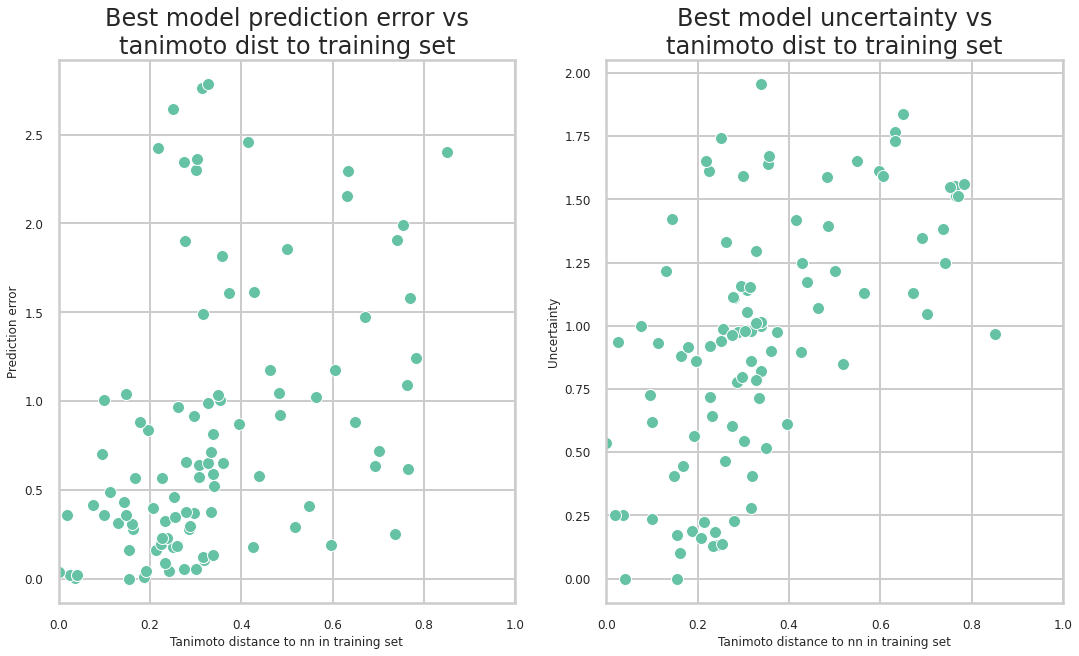

In [ ]:
pred_df=mae_pred
test = pred_df[pred_df.subset=='test']
train = pred_df[pred_df.subset=='train']
# For each compound in the test set, (or new prediction set) find the nearest neighbor in the training set and calculate the distance to that neighbor
test['nnd_train']=cd.calc_dist_smiles('ecfp', 'tanimoto', test.base_rdkit_smiles, train.base_rdkit_smiles, calc_type='nearest', num_nearest=1)
fig, ax = plt.subplots(1,2,figsize=(18,10))
sns.scatterplot(x='nnd_train', y='pred_err', data=test, legend=False, ax=ax[0])
ax[0].set_xlabel("Tanimoto distance to nn in training set")
ax[0].set_ylabel("Prediction error")
ax[0].set_xlim(0, 1)
ax[0].set_title(f"Best model prediction error vs\ntanimoto dist to training set")
# for models without uncertainty, comment this out
sns.scatterplot(x='nnd_train', y=f'{response_col}_std', data=test, ax=ax[1])
ax[1].set_xlabel("Tanimoto distance to nn in training set")
ax[1].set_ylabel("Uncertainty")
ax[1].set_xlim(0, 1)
ax[1].set_title(f"Best model uncertainty vs\ntanimoto dist to training set");

# Predict on new compounds and explore (regression models)

#### Generate predictions on a list of compounds from another target (such as provided by your partners)
- there will be activity values associated with this target. You can explore overlaps between the two targets
- here, my best models are predicting activity of the serotonin receptor, HTR3A
- i will compare with data from the serotonin transporter, SLC6A4

In [ ]:
from atomsci.ddm.utils import curate_data
from atomsci.ddm.utils import struct_utils as su

In [ ]:
# new data must have curated smiles strings, with rdkit standardization, featurizations, etc.
newcmpds = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/SLC6A4_chembl.csv", sep=";")
newcmpds = curate_data.average_and_remove_duplicates('pChEMBL Value', 100, False, data=newcmpds, compound_id='Molecule ChEMBL ID', smiles_col='Smiles')
newcmpds['base_rdkit_smiles']=su.base_smiles_from_smiles(newcmpds.Smiles.tolist())
newcmpds = newcmpds.rename(columns = {'Molecule ChEMBL ID':'compound_id'})
newcmpds = cd.aggregate_assay_data(newcmpds, value_col='VALUE_NUM_mean', output_value_col='VALUE_NUM_mean', label_actives=True, active_thresh=7, id_col='compound_id', smiles_col='base_rdkit_smiles', relation_col = 'Standard Relation')
newcmpds = newcmpds[~newcmpds.base_rdkit_smiles.isna()]
newcmpds = newcmpds[~newcmpds.VALUE_NUM_mean.isna()]
newcmpds = newcmpds[newcmpds.VALUE_NUM_mean!='']
newcmpds.head()

Bad duplicates removed from dataset
Dataframe size (4365, 49)

Dataset de-duplicated
Dataframe size (3783, 49)
New column created with averaged values:  VALUE_NUM_mean
1 entries in input table are missing SMILES strings
3732 unique SMILES strings are reduced to 3729 unique base SMILES strings


,compound_id,base_rdkit_smiles,relation,VALUE_NUM_mean,active
0,CHEMBL361949,CN(C)CCCc1c[nH]c2ccc(F)cc12,,8.40,1
1,CHEMBL469810,N#Cc1ccc2cc(CO[C@H]3CCNC3)ccc2c1,,8.52,1
2,CHEMBL3217176,Cc1cccc(N2CCN(CCCNC(=O)c3nc(C)n(-c4ccccc4)c3C)...,,8.22,1
3,CHEMBL3215620,COc1ccc(-n2c(C)nc(C(=O)NCCCN3CCN(c4cccc(Cl)c4C...,,7.48,1
5,CHEMBL403469,C=CCN(CCC)C(=O)[C@@]1(c2ccc3c(c2)CCO3)C[C@H]1CN,,5.77,0


In [ ]:
ecfp_input_df = newcmpds
rms_pred = predict_from_model_file(model_path= rms_model_path, input_df=ecfp_input_df, id_col='compound_id', smiles_col = 'base_rdkit_smiles', 
                            response_col = 'VALUE_NUM_mean', is_featurized = False, dont_standardize=True)
mae_pred = predict_from_model_file(model_path= mae_model_path, input_df=ecfp_input_df, id_col='compound_id', smiles_col = 'base_rdkit_smiles', 
                            response_col = 'VALUE_NUM_mean', is_featurized = False, dont_standardize=True)

Featurization = DynamicFeaturization with ecfp features


2021-04-09 23:13:17,946 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a42c4f290>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 23:13:17,991 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a39363950>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 23:13:18,065 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a39380c10>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 23:13:18,121 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a39384050>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


number of features: 1024
TIMING: dataset construction took 0.155 s
Loading dataset from disk.


2021-04-09 23:13:30,031 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a39380c10>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 23:13:30,062 Entity <bound method SwitchedDropout.call of <deepchem.models.layers.SwitchedDropout object at 0x7f8a39384050>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'


2021-04-09 23:13:30,198 Unresolved object in checkpoint: (root).optimizer.beta1_power


2021-04-09 23:13:30,201 Unresolved object in checkpoint: (root).optimizer.beta2_power


2021-04-09 23:13:30,204 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-0.kernel


2021-04-09 23:13:30,207 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-0.bias


2021-04-09 23:13:30,212 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-1.kernel


2021-04-09 23:13:30,215 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-1.bias


2021-04-09 23:13:30,217 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-2.kernel


2021-04-09 23:13:30,220 Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).model.layer_with_weights-2.bias


2021-04-09 23:13:30,222 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-0.kernel


2021-04-09 23:13:30,225 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-0.bias


2021-04-09 23:13:30,231 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-1.kernel


2021-04-09 23:13:30,234 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-1.bias


2021-04-09 23:13:30,236 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-2.kernel


2021-04-09 23:13:30,239 Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).model.layer_with_weights-2.bias


2021-04-09 23:13:30,250 A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#loading_mechanics for details.


Featurization = DynamicFeaturization with ecfp features
number of features: 1024
TIMING: dataset construction took 0.145 s
Loading dataset from disk.


In [ ]:
# remember - VALUE_NUM_MEAN_actual here is the IC50 values for target SLC6A4 (that's where the dataset comes from)
# SLC6A4 is a serotonin transporter
# HTR3A is a serotonin receptor
# related targets, but not the same. Will be interesting to see overlaps in activity
display(rms_pred.head(), mae_pred.head())

,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred
846,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,7.115,6.429793
816,CHEMBL101055,COc1cccc(C(CN(C)C)C2(O)CCCCC2)c1,7.060,5.889119
1954,CHEMBL101250,Cc1ccc([C@H]2C[C@H]3CCC4C2[C@](C)(O)CN43)cc1,6.830,5.639379
1004,CHEMBL101899,CN(C)CC(c1cccc(Cl)c1)C1(O)CCCCC1,6.540,6.324660
1471,CHEMBL101905,C=C1CN2C3CC[C@@H]2C[C@H](c2ccc(C)cc2)C13,7.480,5.626943


,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred,VALUE_NUM_mean_std
846,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,7.115,6.665177,0.932679
816,CHEMBL101055,COc1cccc(C(CN(C)C)C2(O)CCCCC2)c1,7.060,5.625227,0.899383
1954,CHEMBL101250,Cc1ccc([C@H]2C[C@H]3CCC4C2[C@](C)(O)CN43)cc1,6.830,6.914835,1.476467
1004,CHEMBL101899,CN(C)CC(c1cccc(Cl)c1)C1(O)CCCCC1,6.540,5.672233,0.855173
1471,CHEMBL101905,C=C1CN2C3CC[C@@H]2C[C@H](c2ccc(C)cc2)C13,7.480,6.492295,1.424312


#### Visualize predictions that don't have ground truth associated with them
- what do the distributions look like? how do they compare?

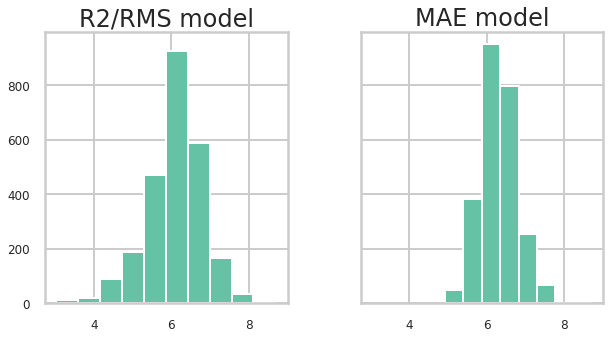

In [ ]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (10,5))
rms_pred.hist('VALUE_NUM_mean_pred', bins=10, ax=ax[0])
ax[0].set_title('R2/RMS model')
mae_pred.hist('VALUE_NUM_mean_pred', bins=8, ax = ax[1])
ax[1].set_title('MAE model');

#### Tanimoto distance from train to new compounds
- what does a tanimoto distance of zero represent?
- what do you think about the distances between your training data and the new data? are the compounds similar or different?
- what do you think this means for the uncertainty of new predictions?

In [ ]:
from atomsci.ddm.pipeline import chem_diversity as cd

In [ ]:
htr3a=h1
calc_type='nearest'
dist_metric='tanimoto'
smiles_lst2=newcmpds.base_rdkit_smiles.tolist()
htr3a=htr3a.merge(split_df, left_on='compound_id', right_on='cmpd_id')
smiles_lst1=htr3a[htr3a.subset=='train'].base_rdkit_smiles.tolist()
dists=cd.calc_dist_smiles('ECFP',dist_metric,smiles_lst2,smiles_lst1,calc_type)
distsdf=pd.DataFrame([smiles_lst2,list(dists)], columns=range(len(smiles_lst2)), index=['smiles','dists']).T
df=newcmpds
df=df.merge(distsdf, left_on='base_rdkit_smiles', right_on='smiles')
print(len(set(smiles_lst2)-set(smiles_lst1)))
print(list(df.loc[df.dists==0, 'compound_id']))

2487
['CHEMBL4128926', 'CHEMBL3942511', 'CHEMBL3963788', 'CHEMBL1729', 'CHEMBL444985', 'CHEMBL42', 'CHEMBL2047574', 'CHEMBL30713', 'CHEMBL56564', 'CHEMBL2204360', 'CHEMBL2391541', 'CHEMBL453996']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


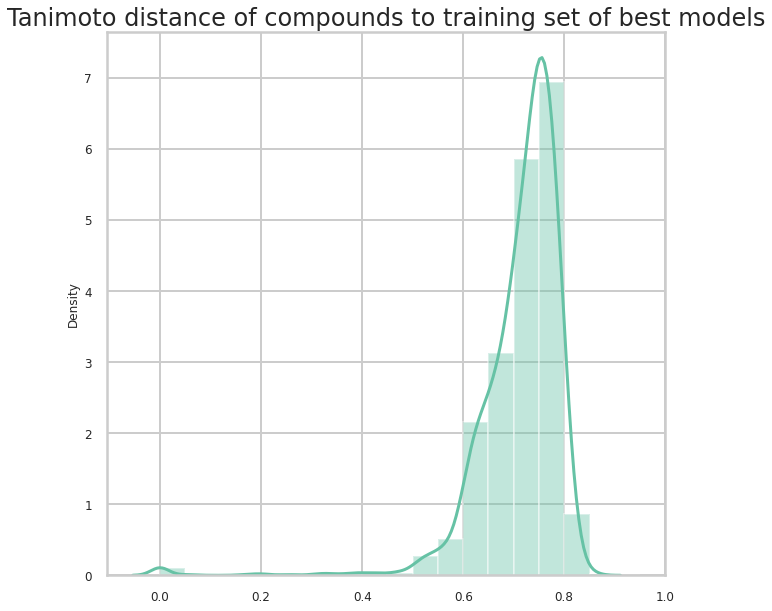

In [ ]:
fig, axes = plt.subplots(1, figsize=(10,10))
sns.distplot(dists, ax=axes, bins=np.arange(-0.05,1,0.05))
axes.set_title("Tanimoto distance of compounds to training set of best models");

#### Uncertainty of new predictions
- do you see a correlation between uncertainty and magnitude of prediction?

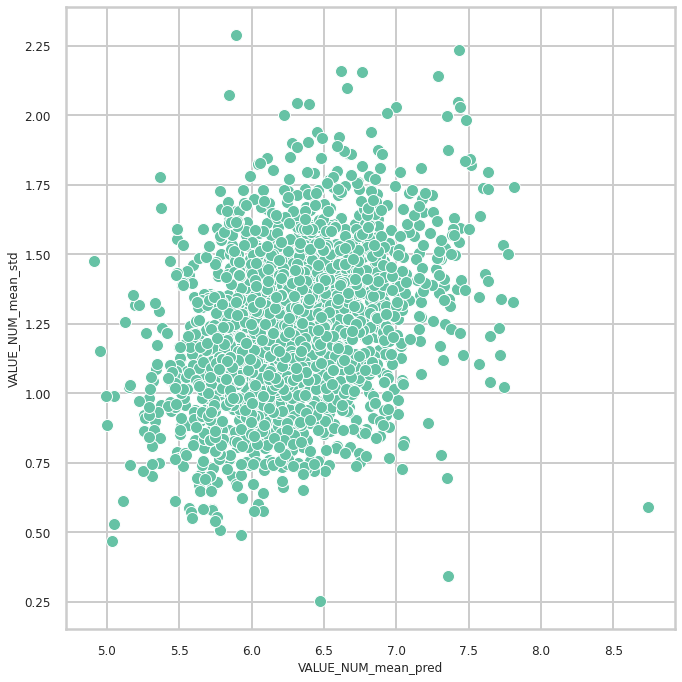

In [ ]:
pred_df=mae_pred
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(x=f'{response_col}_pred', y=f'{response_col}_std',  data=pred_df, ax=ax);
plt.tight_layout()

#### Uncertainty vs tanimoto distance
- do you see correlations?

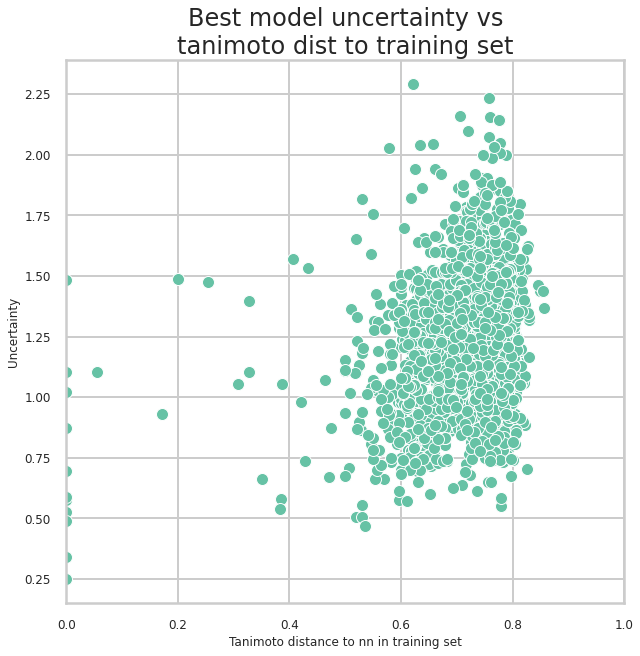

In [ ]:
pred_df=mae_pred
pred_df=pred_df.merge(df)
fig, ax = plt.subplots(1,figsize=(10,10))
# for models without uncertainty, comment this out
sns.scatterplot(x='dists', y=f'{response_col}_std', data=pred_df, ax=ax)
ax.set_xlabel("Tanimoto distance to nn in training set")
ax.set_ylabel("Uncertainty")
ax.set_xlim(0, 1)
ax.set_title(f"Best model uncertainty vs\ntanimoto dist to training set");

#### Compare predictions for your target vs ground truth for another target
- do you see any compounds that are selective for your target or the other target? 
  - you can define selectivity as 1000x more potent for one target vs another, so 3 units of pXC50 values
- How similar are the compound activities for the two targets?

In [ ]:
rms_pred['selective'] = abs(rms_pred.VALUE_NUM_mean_actual - rms_pred.VALUE_NUM_mean_pred)>3
mae_pred['selective'] = abs(mae_pred.VALUE_NUM_mean_actual - mae_pred.VALUE_NUM_mean_pred)>3

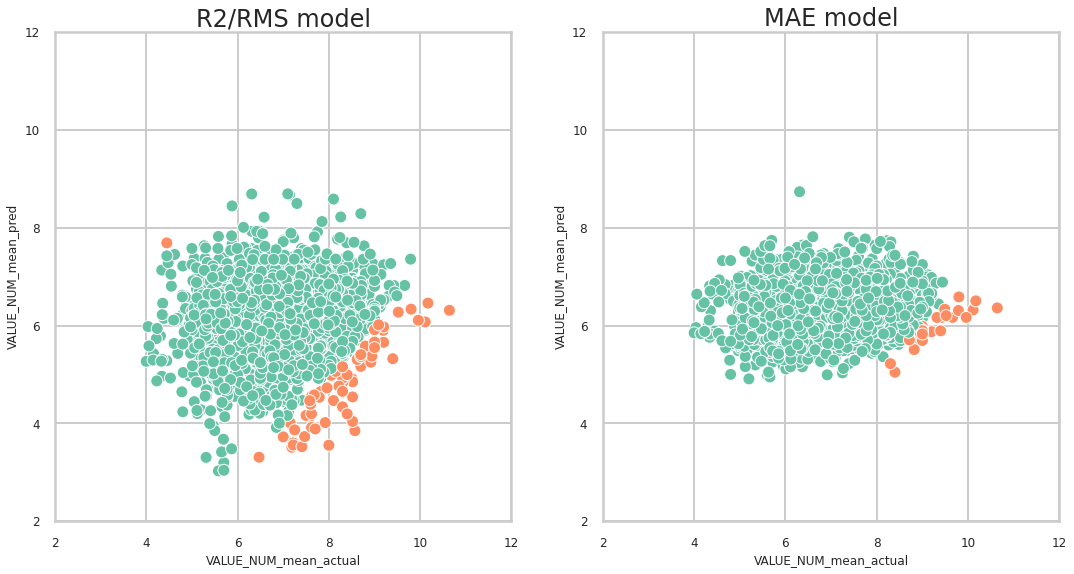

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,9))
sns.scatterplot(data=rms_pred, x=f'{response_col}_actual', y=f'{response_col}_pred', ax=ax[0], hue='selectivity', legend=False)
sns.scatterplot(data=mae_pred, x=f'{response_col}_actual', y=f'{response_col}_pred', ax=ax[1], hue = 'selectivity', legend=False)
ax[0].set_xlim([2,12]); ax[0].set_ylim([2,12])
ax[1].set_xlim([2,12]); ax[1].set_ylim([2,12])
ax[0].set_title('R2/RMS model')
ax[1].set_title('MAE model');

# Choose best model and examine predictions (classification models)
Metrics to assess classification models: (google definitions)
- cross_entropy
- kappa
- matthews_cc
- npv
- prc_auc_score
- precision
- recall_score
- roc_auc_score

#### select best models & visualize metrics with radar plot

In [ ]:
# best models per metric
top_xnt_model = perf_df[perf_df.valid_cross_entropy==perf_df.valid_cross_entropy.min()] # minimize cross entropy, maximize rest
top_kap_model = perf_df[perf_df.valid_kappa==perf_df.valid_kappa.max()]
top_mcc_model = perf_df[perf_df.valid_matthews_cc==perf_df.valid_matthews_cc.max()]
top_npv_model = perf_df[perf_df.valid_npv==perf_df.valid_npv.max()]
top_prc_model = perf_df[perf_df.valid_prc_auc_score==perf_df.valid_prc_auc_score.max()]
top_pre_model = perf_df[perf_df.valid_precision==perf_df.valid_precision.max()]
top_rec_model = perf_df[perf_df.valid_recall_score==perf_df.valid_recall_score.max()]
top_roc_model = perf_df[perf_df.valid_roc_auc_score==perf_df.valid_roc_auc_score.max()] 

display(top_xnt_model, top_kap_model, top_mcc_model, top_npv_model, top_prc_model, top_pre_model, top_rec_model, top_roc_model)
# note: only two different model_uuids here; note featurizer & featurizer types

,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1833,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,bb9d4274-55f2-40b2-9a7e-d74d356d1b2b,1.618016e+09,classification,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,16.0,32.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,active,801,0.998746,0.999011,0.982522,0.97807,0.991111,0.988406,0.964547,0.964435,0.10687,100,0.898305,0.876769,0.81,0.73913,0.829268,0.87037,0.617635,0.614448,0.41889,101,0.926022,0.919234,0.831683,0.770833,0.860465,0.886792,0.664185,0.660873,0.370678


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1572,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,6112f135-53c1-44ec-83d2-5313157ee5f3,1.618019e+09,classification,RF,computed_descriptors,mordred_filtered,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,16.0,64.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,989,active,792,0.999227,0.999389,0.988636,0.986755,0.993333,0.99115,0.976847,0.976818,0.115104,96,0.887583,0.862662,0.833333,0.755102,0.902439,0.914894,0.677089,0.667676,0.467103,101,0.881716,0.868409,0.811881,0.76087,0.813953,0.854545,0.619841,0.618716,0.461152


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1572,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,6112f135-53c1-44ec-83d2-5313157ee5f3,1.618019e+09,classification,RF,computed_descriptors,mordred_filtered,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,16.0,64.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,989,active,792,0.999227,0.999389,0.988636,0.986755,0.993333,0.99115,0.976847,0.976818,0.115104,96,0.887583,0.862662,0.833333,0.755102,0.902439,0.914894,0.677089,0.667676,0.467103,101,0.881716,0.868409,0.811881,0.76087,0.813953,0.854545,0.619841,0.618716,0.461152


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1830,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,156cc446-79b5-400e-92d9-ecb479426b86,1.618016e+09,classification,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,32.0,24.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,active,801,0.998145,0.998587,0.978777,0.975824,0.986667,0.982659,0.956904,0.956827,0.118024,100,0.877635,0.864475,0.81,0.711538,0.902439,0.916667,0.638125,0.622716,0.467096,101,0.922614,0.91159,0.841584,0.77551,0.883721,0.903846,0.686672,0.681764,0.387732


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1833,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,bb9d4274-55f2-40b2-9a7e-d74d356d1b2b,1.618016e+09,classification,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,16.0,32.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,active,801,0.998746,0.999011,0.982522,0.97807,0.991111,0.988406,0.964547,0.964435,0.10687,100,0.898305,0.876769,0.81,0.73913,0.829268,0.87037,0.617635,0.614448,0.41889,101,0.926022,0.919234,0.831683,0.770833,0.860465,0.886792,0.664185,0.660873,0.370678


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1710,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,75d5d415-08f0-4653-81de-a46e5001e739,1.618024e+09,classification,RF,computed_descriptors,mordred_filtered,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,512.0,24.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,989,active,792,0.99899,0.999168,0.988636,0.991091,0.988889,0.985423,0.976853,0.97685,0.107622,96,0.883592,0.814892,0.822917,0.8,0.780488,0.839286,0.637156,0.637011,0.79543,101,0.849639,0.841955,0.80198,0.755556,0.790698,0.839286,0.597934,0.597449,0.482292


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1572,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,6112f135-53c1-44ec-83d2-5313157ee5f3,1.618019e+09,classification,RF,computed_descriptors,mordred_filtered,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,16.0,64.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,989,active,792,0.999227,0.999389,0.988636,0.986755,0.993333,0.991150,0.976847,0.976818,0.115104,96,0.887583,0.862662,0.833333,0.755102,0.902439,0.914894,0.677089,0.667676,0.467103,101,0.881716,0.868409,0.811881,0.76087,0.813953,0.854545,0.619841,0.618716,0.461152
1830,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,156cc446-79b5-400e-92d9-ecb479426b86,1.618016e+09,classification,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,32.0,24.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,active,801,0.998145,0.998587,0.978777,0.975824,0.986667,0.982659,0.956904,0.956827,0.118024,100,0.877635,0.864475,0.810000,0.711538,0.902439,0.916667,0.638125,0.622716,0.467096,101,0.922614,0.911590,0.841584,0.77551,0.883721,0.903846,0.686672,0.681764,0.387732


,collection,model_uuid,time_built,prediction_type,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_roc_auc_score,train_prc_auc_score,train_accuracy_score,train_precision,train_recall_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,valid_size,valid_roc_auc_score,valid_prc_auc_score,valid_accuracy_score,valid_precision,valid_recall_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,test_size,test_roc_auc_score,test_prc_auc_score,test_accuracy_score,test_precision,test_recall_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy
1833,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,bb9d4274-55f2-40b2-9a7e-d74d356d1b2b,1.618016e+09,classification,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,16.0,32.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,active,801,0.998746,0.999011,0.982522,0.97807,0.991111,0.988406,0.964547,0.964435,0.10687,100,0.898305,0.876769,0.81,0.73913,0.829268,0.87037,0.617635,0.614448,0.41889,101,0.926022,0.919234,0.831683,0.770833,0.860465,0.886792,0.664185,0.660873,0.370678


# Explore the domain of applicability of your model

#### Make sure you have featurized data to use for UMAPs
graphconv you can't do umaps

In [ ]:
newcmpds.to_csv("/content/drive/MyDrive/Columbia_E4511/SLC6A4_chembl_cur.csv")

In [ ]:
# to create umaps on training data, you need features for the model type.
# rdkit and mordred should already be featurized if you built models with them
# ecfp doesn't have saved features, so extract them now for the training data and new data
# just change the train_file to featurize the other dataset
from atomsci.ddm.pipeline import featurization as feat

train_file = "/content/drive/MyDrive/Columbia_E4511/SLC6A4_chembl_cur.csv"
response_col = "VALUE_NUM_mean"
compound_id = "compound_id"
smiles_col = "base_rdkit_smiles"
result_dir = "/content/drive/MyDrive/Columbia_E4511/HTR3A_models"
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        # "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": result_dir,
        "featurizer":"ecfp"
    }
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
featurization=None
# comment out this line after splitting once so you don't re-split
MP.run_mode = 'training'
MP.params.split_only = True
MP.params.previously_split = False
if featurization is None:
    featurization = feat.create_featurization(MP.params)
MP.featurization = featurization
MP.load_featurize_data()

number of features: 1024


In [ ]:
ecfp = MP.data.dataset.X
y=MP.data.dataset.y
ids=MP.data.dataset.ids
yids = [ids, y]
yids.extend(ecfp.T)
ecfpfeats = pd.DataFrame(yids).T
ecfp_colnames = ['compound_id', 'mol_wt']
col2 = list(range(0,1024))
col2 = ['ecfp_'+ str(x) for x in col2]
ecfp_colnames.extend(col2)
ecfpfeats.columns = ecfp_colnames
ecfpfeats.to_csv('/content/drive/MyDrive/Columbia_E4511/scaled_descriptors/SLC6A4_chembl_cur_with_ecfp_descriptors.csv')

#### UMAP projection of new compounds onto the training dataset
- create umap of training data
- use the mapper object to project new compounds onto the training data
- visualize prediction uncertainty or ADI as hue

In [ ]:
display(top_r2_model, top_rms_model, top_mae_model)

,collection,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
1240,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,44080ec3-f88a-469e-ae3d-7a0c31d4a768,1.617830e+09,NN,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,"64,16","0.20,0.20",0.01,38.0,70.0,NaN,NaN,NaN,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,VALUE_NUM_mean,801,0.917906,0.346156,0.457862,100,0.61227,0.783147,1.090699,101,0.636958,0.731418,1.04145


,collection,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
1240,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,44080ec3-f88a-469e-ae3d-7a0c31d4a768,1.617830e+09,NN,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,"64,16","0.20,0.20",0.01,38.0,70.0,NaN,NaN,NaN,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,VALUE_NUM_mean,801,0.917906,0.346156,0.457862,100,0.61227,0.783147,1.090699,101,0.636958,0.731418,1.04145


,collection,model_uuid,time_built,model_type,featurizer,features,transformer,splitter,split_strategy,split_uuid,umap_dim,umap_targ_wt,umap_neighbors,umap_min_dist,layer_sizes,dropouts,learning_rate,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,dataset_bucket,dataset_key,dataset_size,parameter,train_size,train_r2_score,train_mae_score,train_rms_score,valid_size,valid_r2_score,valid_mae_score,valid_rms_score,test_size,test_r2_score,test_mae_score,test_rms_score
250,/content/drive/MyDrive/Columbia_E4511/HTR3A_mo...,fe2edb07-def9-4e56-9745-276a39eafcd4,1.617742e+09,RF,ecfp,ecfp,normalization,scaffold,train_valid_test,ead9410d-7abc-41cc-8713-f78dac0106a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,128.0,24.0,NaN,NaN,public,/content/drive/MyDrive/Columbia_E4511/HTR3A_cu...,1002,VALUE_NUM_mean,801,0.947466,0.244521,0.366269,100,0.575538,0.758454,1.141195,101,0.587288,0.81692,1.110412


In [ ]:
import umap

In [ ]:
cols_dict={
    'ecfp':('ecfp_0','ecfp_1023'),
    'mordred_filtered':('ABC','SsBr'),
    'rdkit_raw':('MaxEStateIndex','fr_urea'),
}
# features model was created on, for training data
feat_type = 'ecfp'
feats = pd.read_csv(f"/content/drive/MyDrive/Columbia_E4511/scaled_descriptors/HTR3A_curated_with_{feat_type}_descriptors.csv")
valuecol=[f'VALUE_NUM_mean']
feats = feats.merge(split_df, left_on='compound_id', right_on='cmpd_id')
feats = feats.merge(h1)
feats = feats[feats.subset=='train']
feats = feats.dropna(subset = valuecol).reset_index(drop=True)
# select only the non-na feature columns to run umap on
firstcol, lastcol=cols_dict[feat_type]
maptrain = feats.loc[:,firstcol:lastcol]
maptrain = maptrain.dropna(axis='columns')
maptraincols = maptrain.columns
# get same feature columns from new compound df
featnew=pd.read_csv(f"/content/drive/MyDrive/Columbia_E4511/scaled_descriptors/SLC6A4_chembl_cur_with_{feat_type}_descriptors.csv", index_col=False)
featnew=featnew.merge(mae_pred)
mapnew = featnew.loc[:,firstcol:lastcol]
mapnew = mapnew.dropna(axis='columns')
mapnewcols = mapnew.columns
allcols = list(set(maptraincols).intersection(set(mapnewcols)))
maptrain = maptrain[allcols]
mapnew= mapnew[allcols]
# create umap on training data
mapper=umap.UMAP(n_neighbors=15, n_components=2, metric='jaccard', random_state=42).fit(maptrain)
maptrain_coords = pd.DataFrame(mapper.embedding_, columns=('UMAP_X', 'UMAP_Y'))
feats=pd.concat([feats,maptrain_coords], axis=1)
# use mapper to create umap coords for new data
mapnew_coords = pd.DataFrame(mapper.transform(mapnew), columns = ('UMAP_X', 'UMAP_Y'))
featnew=pd.concat([featnew,mapnew_coords], axis=1)
featnew=featnew.merge(newcmpds)
featnew=featnew.sort_values('active')

/usr/local/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


- Do you see any observations about your predictions being more uncertain when they are more isolated or further away from other things in the UMAP projection?

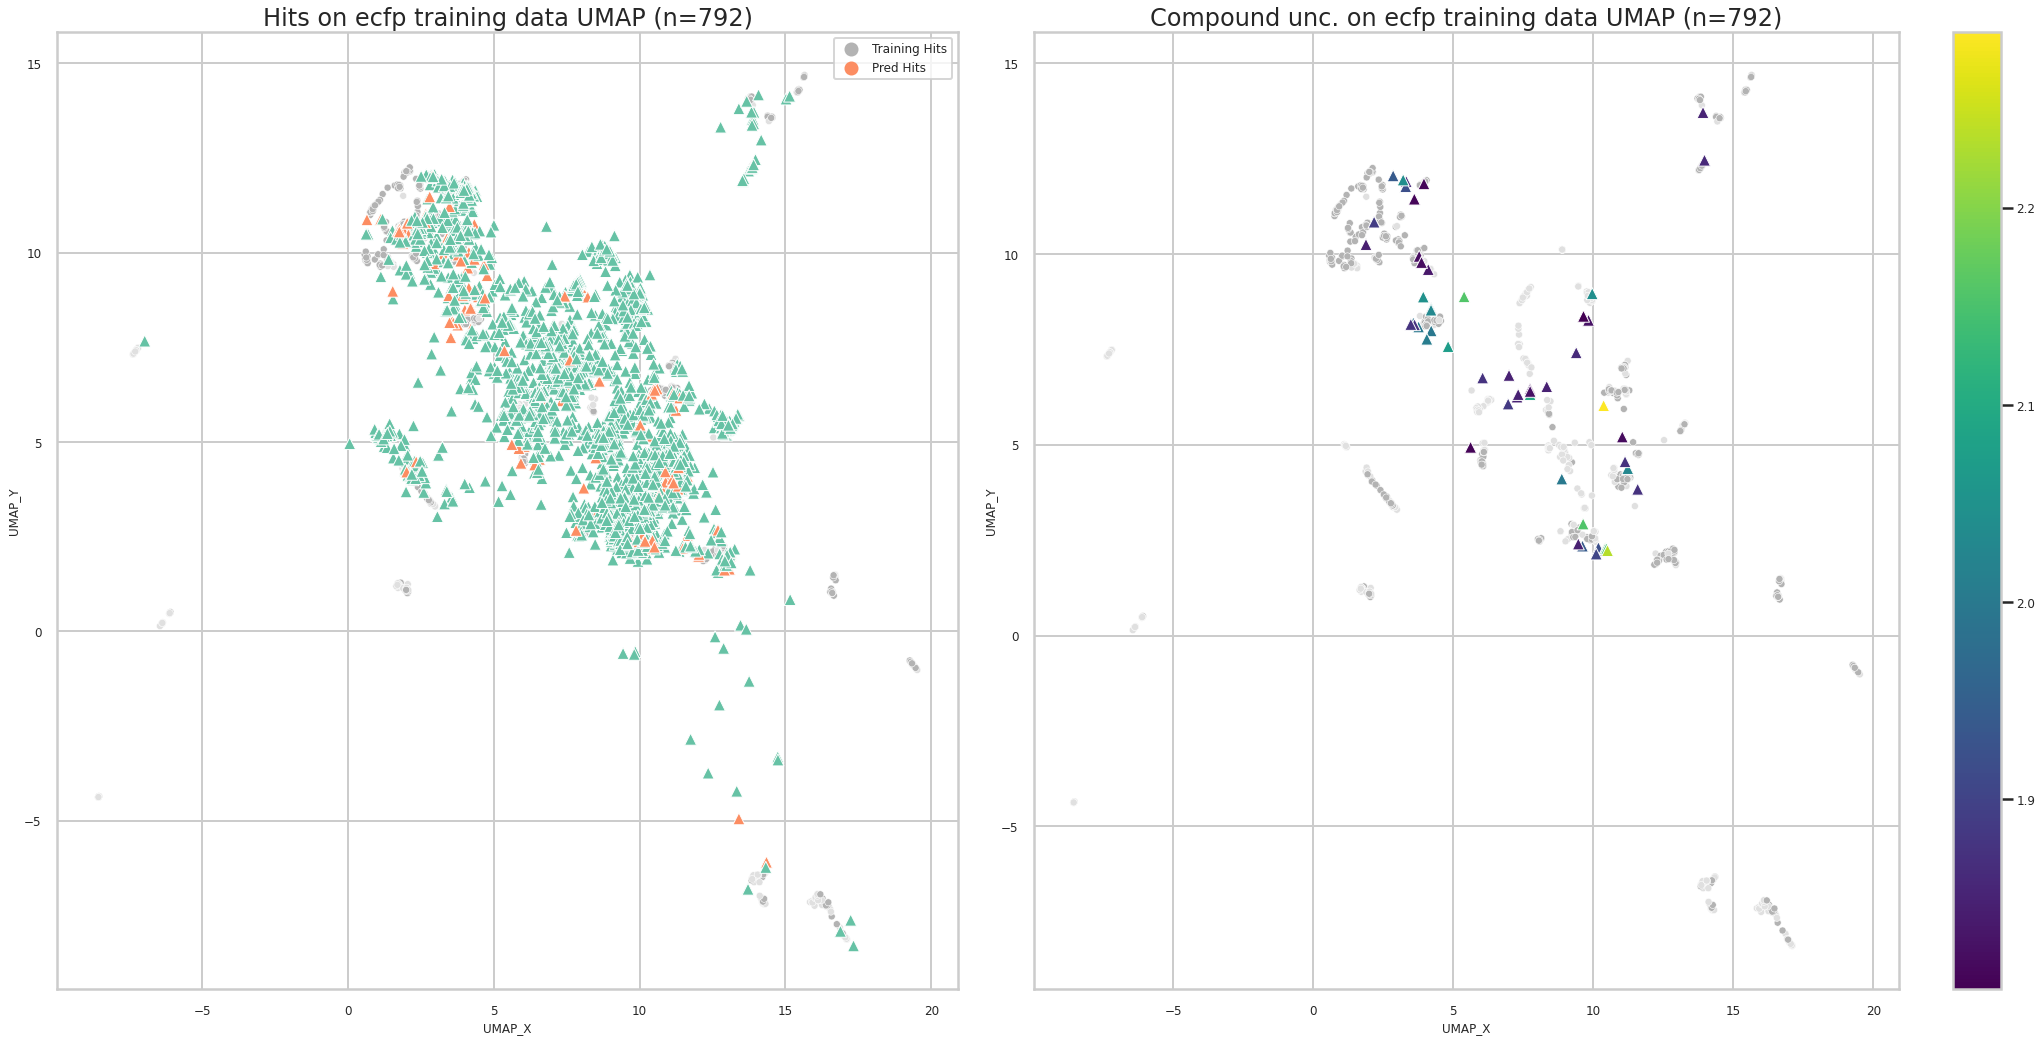

In [ ]:
# plot
fig, ax = plt.subplots(1,2, figsize=(30,15), gridspec_kw={'width_ratios': [1, 1.2]})
# plot with active / inactive labels
sns.scatterplot(x=feats['UMAP_X'], y=feats["UMAP_Y"], s=50, hue=feats['active'].map({0:False, 1:True}), palette=['#e0e0e0','#b3b3b3'], ax=ax[0])
sns.scatterplot(x=featnew['UMAP_X'], y=featnew["UMAP_Y"], hue=featnew[f'VALUE_NUM_mean_pred']>7, palette='Set2', marker = '^', legend='full', ax=ax[0])
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend([handles[1],handles[-1]], [f'Training Hits', f'Pred Hits'], fontsize=12)
ax[0].set_title(f'Hits on {feat_type} training data UMAP (n={len(feats)})')
# plot with continuous labels
valcol=f'VALUE_NUM_mean_std'
# reduce number of points to plot
plotnew = featnew[featnew[valcol]>1.8]
norm = plt.Normalize(plotnew[valcol].min(), plotnew[valcol].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
sns.scatterplot(x=feats['UMAP_X'], y=feats["UMAP_Y"], s=50, hue=feats['active'], palette=['#e0e0e0','#b3b3b3'], ax=ax[1])
sns.scatterplot(x=plotnew['UMAP_X'], y=plotnew["UMAP_Y"], hue=plotnew[valcol], palette='viridis', marker = '^', ax=ax[1]);
# Remove the legend and add a colorbar
ax[1].get_legend().remove()
ax[1].figure.colorbar(sm)
ax[1].set_title(f'Compound unc. on {feat_type} training data UMAP (n={len(feats)})');
plt.tight_layout()

# 